# ANALYSING THE CALABRIAN MAFIA WITH NETWORKX


Chief Prosecutor Nicola Gratteri has been told that he's 'un morto che cammina’, a dead man walking. “Until recently I was never frightened. But since these latest threats I have felt fear. The fear is real. It’s there”. Italy's biggest mafia trial since the 1980s has just begun, and his job is to gain convictions against more than three hundred members of the Ndrangheta, one of the most dangerous criminal organisations in the world.

For decades the Calabrian mafia, the Ndrangheta, was the poor cousin of Sicily's Cosa Nostra and the Camorra of Naples. Overlooked by Hollywood, the Ndrangheta was little known outside of its home turf, the remote and rugged hillsides that make up the 'toe' of Italy's 'boot'. It's core businesses were extortion and kidnapping. Its structure, based around close-knit families or clans, made it almost impossible for law-enforcement to penetrate. 

Everything changed when the Ndrangheta formed ties with the South American cartels, and took a grip on the European cocaine market. In 2013, a report by the Demoskopia research institute claimed the ’Ndrangheta had a turnover of £44bn, more than Deutsche Bank and McDonald’s combined. CNN estimates that it controls up to 80% of the cocaine coming into Europe.

Along with this growth the Ndrangheta also expanded its reach, coming to dominate the underworld in the northern Italian district of Lombardy. These changes came with a higher profile. In 2007 the Ndrangeta made international headlines, when a feud between two clans saw six members gunned down outside a pizzeria in the small town of Duisburg in western Germany. The following year Carmelo Novella, the head of the Ndrangheta in Lombardy, was murdered in a bar in San Vittore Olona, a small town outside Milan. His demands for more autonomy had angered the bosses back home in Calabria.

This period of turbulence coincided with Operation Infinito, launched by the authorities in Lombardy against the Ndrangheta. Two years of surveillance tracked the movements and interactions of more than a hundred mafiosi. It culminated with the recording in October 2009 of the Summit di Paderno Dugnano, where senior gangsters met to elect a successor to Carmelo Novella. In 2010, the evidence gathered during Operation Infinito formed the basis for dozens of indictments, mostly on charges of participation in a mafia-type organisation - defined by an omerta of silence and the power to intimidate as a group. 

Once these cases were concluded, the authorities released the pre-trial detention order triggered by the preliminary investigation judge. This contained details of the surveillance carried out during Operation Infinito. A decade later, as the Ndrangeta again finds itself in the dock, this data may provide the best  
insight into the structure of its leadership.

The dataset can be downloaded here:
https://sites.google.com/site/ucinetsoftware/datasets/covert-networks/ndranghetamafia2



# PART 1: VISUALISING THE NETWORK

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
sns.set_style('darkgrid')
from matplotlib import cm
from networkx.algorithms import bipartite
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm


In [2]:
mafia = pd.read_csv('NDRANGHETAMAFIA_2M.csv')
mafia.head()

Unnamed: 0  \
0  ALBANESE Giuseppe Domenico   
1             ALVIANO Umberto   
2         ANGHELONE Francesco   
3               ARENA Carmelo   
4             ARENA Salvatore   

   18/10/2007(L), summit-dinner at "la cadgrega" restaurant in Limito di Pioltello (Mi)  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                  0                                      
4                                                  0                                      

   29/11/2007(L),  summit-dinner at "la cadgrega" restaurant in Limito di Pioltello (Mi)  \
0                                                  0                                       
1                                                  0                                       
2                                                  0                                       
3                                                  0                                       
4                                                  0                                       

   02/02/2008(L), summit-dinner at "Bar trattoria da Marina" in S.Pietro all'Olmo, Cornaredo (Mi)  \
0                                                  0                                                
1                                                  0                                                
2                                                  0                                                
3                                                  0                                                
4                                                  0                                                

   15/02/2008(1) meeting at "The Sun” bar in San Vittore Olona  \
0                                                  0             
1                                                  0             
2                                                  0             
3                                                  0             
4                                                  0             

   15/02/2008(2) dinner at Borgo Antico restaurant (Legnano)  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   21/02/2008(L), summit-dinner at "da Rosario e Maria" restaurant - Cornaredo (Mi)  \
0                                                  0                                  
1                                                  0                                  
2                                                  0                                  
3                                                  0                                  
4                                                  0                                  

   '26/02/2008 dinner at “Il Palio” restaurant (Legnano)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   01/03/2008 new opening of “Cadrega” restaurant (Pioltello)  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   12/03/2008(L), “Ricottata” at “giardino degli ulivi” 

In [4]:
# the column names are inconvenient and inconsistent
# make a copy of the original dataset, and clean up the column names 
# use regex to just keep the dates of the meetings for now plus any brackets reference (1,2 etc)

mafia_copy = mafia.copy()
pattern = r'(\d{2}/\d{2}/\d{4}(\(\w\))?\w?)'
new_cols = mafia.columns[1:].str.extract(pattern).loc[:,0].values
cols_dict = {}
for i, col in enumerate(mafia.columns[1:]):
    cols_dict[col] = new_cols[i]
mafia = mafia.rename(columns = cols_dict)
mafia.head()

Unnamed: 0  18/10/2007(L)  29/11/2007(L)  02/02/2008(L)  \
0  ALBANESE Giuseppe Domenico              0              0              0   
1             ALVIANO Umberto              0              0              0   
2         ANGHELONE Francesco              0              0              0   
3               ARENA Carmelo              0              0              0   
4             ARENA Salvatore              0              0              0   

   15/02/2008(1)  15/02/2008(2)  21/02/2008(L)  26/02/2008  01/03/2008  \
0              0              0              0           0           0   
1              0              0              0           0           0   
2              0              0              0           0           0   
3              0              0              0           0           0   
4              0              0              0           0           0   

   12/03/2008(L)  ...  23/05/2009  30/05/2009  18/06/2009(L)  26/06/2009(L)  \
0              0  ...           0           0              0              0   
1              0  ...           0           0              0              0   
2              0  ...           0           0              0              0   
3              0  ...           0           0              0              0   
4              0  ...           0           0              0              0   

   11/07/2009  24/07/2009(L)  03/08/2009(L)  16/09/2009  02/10/2009  \
0           0              0              0           0           0   
1           0              0              0           0           0   
2           0              0              1           0           0   
3           0              0              0           0           0   
4           0              0              0           0           0   

   31/10/2009  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 48 columns]

**VISUALISING THE ATTENDENCE OF MEETINGS**

- The dataset refers to 48 meetings which took place over a two year period. More than 150 mafiosi were involved, but only a handful typically attended any given meeting - the matrix is quite sparse. 


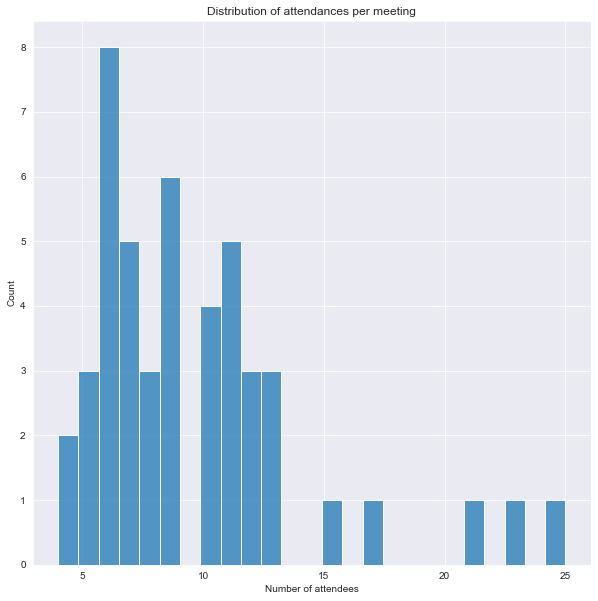

In [5]:
#visualise how many mafiosi typically attended each meeting
#meetings typically had 7-12 participants, a handful had significantly more

fig, ax = plt.subplots(figsize = (10, 10))
sns.histplot(mafia.sum()[1:], bins = 25, ax = ax)
plt.title('Distribution of attendances per meeting')
plt.xlabel('Number of attendees')
plt.show()

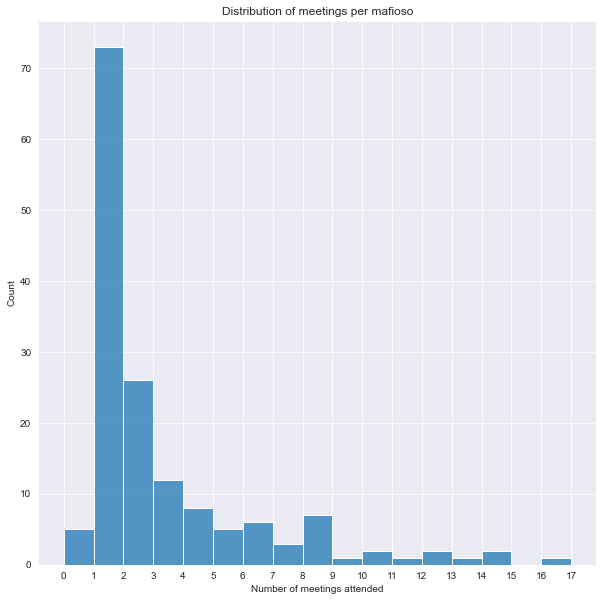

In [6]:
#visualise how many meetings each mafioso typically attended
#most mafiosi only attended one meeting, or perhaps two 
#a few attended a lot more

fig, ax = plt.subplots(figsize = (10, 10))
sns.histplot(mafia.sum(axis = 1)[1:], bins = 17, ax = ax)
plt.title('Distribution of meetings per mafioso')
plt.xticks(range(18))
plt.xlabel('Number of meetings attended')
plt.show()

**REMOVE FIVE MAFIOSI WITH NO CONNECTIONS**
- We can see that there there are five mafiosi who didn't attend any meetings. 
- Presumably they were on a list of suspects for observation, but it looks like they failed to show up for any meetings. 
- These five will make it harder to visualize the data, so it makes sense to drop them before we go further.

In [7]:
mafia = mafia[mafia.sum(axis = 1) != 0].reset_index(drop = True)

**CREATE A BIPARTITE NETWORK**

- Now that we have removed the five mafiosi who failed to make it to any meetings, it would be good to see if we can visualise the relationship more clearly between the mobsters and the meetings that they attended.
- We can do this by using NetworkX to create a bipartite network, with meetings in one group and mafiosi in the other.


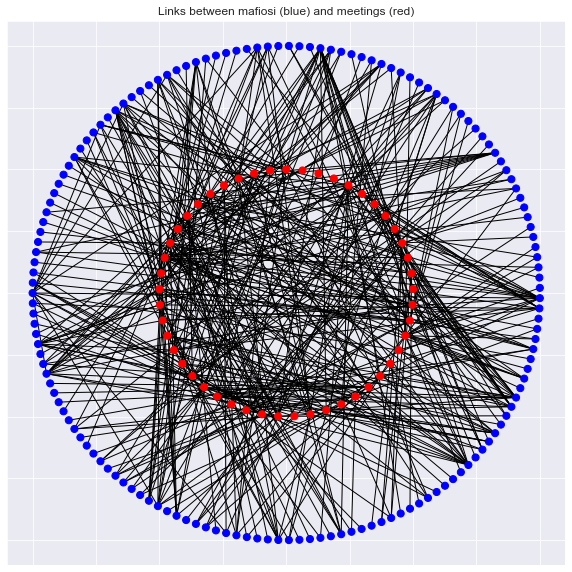

In [270]:
# create a bipartite network graph with NetworkX
B = nx.Graph()
B.add_nodes_from(list(mafia['Unnamed: 0'].index), bipartite = 0)
B.add_nodes_from(list(range(1000, (len(mafia.columns) -1) *1000, 1000)), bipartite = 1)


# separate lists for nodes representing meetings and mafiosi
top_nodes = [n for n, d in dict(B.nodes()).items() if d['bipartite'] == 0]
bottom_nodes = [n for n, d in dict(B.nodes()).items() if d['bipartite'] == 1]


# iterate through dataframe - where mafiosi has attended a specific meeting, add an 'edge' to a list of edges
B_edge_list = []
for i, row in mafia.iterrows():
    for j,col in enumerate(list(mafia.columns[1:])):
        if mafia.loc[i, col] == 1:
            edge = (i, j*1000)
            B_edge_list.append(edge)
B.add_edges_from(B_edge_list)


# plot the graph
shells = [list(bottom_nodes), list(top_nodes)]
positions = nx.shell_layout(B, shells)
fix, ax = plt.subplots(figsize = (10, 10))
plt.title('Links between mafiosi (blue) and meetings (red)')
nx.draw_networkx(B, pos = positions, ax = ax, with_labels = False, node_size = 50, node_color =  ['blue'] * len(top_nodes) + ['red'] * (len(bottom_nodes)))
plt.savefig('bipartite.png')

**VISUALISING THE RELATIONSHIPS BETWEEN MAFIOSI**
- The bipartite network has allowed us to visualise the relationship between mafiosi and meetings.
- An undirected graph will allow us to model the relationships between mafiosi and other mafiosi.
- First, there is some data-cleaning to be done, specifically around the names of the mafiosi.
- There are several challenges involved in cleaning up the names column from the dataset. Some mafiosi are referred to by only their first names. Some of them have double barrelled surnames (eg 'De Marco'). Some of them have a single christian name, others have two.
- To deal with this, it will be necessary to write four functions. The first will provied the mafioso with a fictitious surname ('X') if he doesn't already have one. This will enable a second function to extract the surname, a third to remove punctuation, and a fourth to extract christian name(s).


In [9]:
# function to add surname 'X' to characters with only a first name

def insert_surname(name):
    if len(name.split()) == 1:
        name = f'X_{name.split()[0]} ' + name 
    return name

In [10]:
# function to extract the surname (whether or not it is double-barrelled)

def extract_surname(name):
    if name.split()[1].upper() ==  name.split()[1]:
        return ' '.join(name.split()[:2])
    else:
        return name.split()[0]

In [11]:
# function to remove punctuation from surnames
import re

def clean_surname(name):
    new = re.sub(r'[^\w\s]', '', name)
    return new

In [12]:
# function to extract christian names
import re

def extract_christian_names(name):
    pattern = r'([A-Z][a-z]\w+)'
    name_list = re.findall(pattern, name)
    christian =  ' '.join(name_list)
    return christian

In [13]:
# create three new columns in the dataset, one for cleaned-up surnames, one for cleaned-up first names, and one for the two concatenated together

mafia['surnames'] = mafia['Unnamed: 0'].apply(insert_surname).apply(extract_surname).apply(clean_surname)
mafia['first_names'] = mafia['Unnamed: 0'].apply(extract_christian_names)
mafia['names'] = mafia['first_names'] +' '+ mafia['surnames']

**EXTRACTING INFORMATION FROM THE DATASET TO BUILD DATAFRAME OF NODES AND EDGES FOR NETWORK ANALYSIS**

- The data is currently in the form of a sparse matrix. The rows are individual mafiosi, the columns are meetings, and the data is recorded as '1' for attendance and '0' for non-attendance.
- To conduct network analysis with NetworkX, we will need to convert this into nodes and edges which can be used for graphing. The nodes are simple, these are the mafiosi themselves. We can add an attribute to each node based on 'family_size', or how often the specific surname occurs within the data.
- The edges will require a bit of pre-processing. Each edge is a connection between two mafiosi, a connection occuring when they both attend the same meeting.
- To extract this information, we will transpose the dataframe, interate through the rows of meetings, and whenever a specific mafiosi has attended that meeting his name will be appended to a list within a default dictionary. The Combinations class from itertools allows us to iterate over those names, creating a new list of edges for each meeting. 


In [14]:
# create dataframe of weighted edges from raw data

from collections import defaultdict
from itertools import combinations


#copy and transpose dataframe
mafia_2 = mafia.copy().set_index('names')
mafia_2.index.name = None
mafia_2 = mafia_2.T


#create lists of attendees for each meeting and collect in dictionary
meetings = defaultdict(list)
for index, row in mafia_2.iterrows():
    for col in list(mafia_2.columns):
        if mafia_2.loc[index,col] == 1:
            meetings[index].append(col)
            
            
#create list of network edges from lists of attendees      
edges_list = []
for k, v in meetings.items():
    edges = list(combinations(v,2))
    edges_list.append(edges)

    
#flatten the list of lists and assemble in a dataframe
flat_edges_list = [item for sublist in edges_list for item in sublist]
edges_df = pd.DataFrame(flat_edges_list, columns = ['source', 'target'])


#add weights to each edge, based on how often each mafiosi 'pairing' occured
weighted_edges_df = pd.DataFrame(edges_df.groupby(['source', 'target']).size().reset_index())
weighted_edges_df = weighted_edges_df.rename(columns = {0: 'weight'})
weighted_edges_df.head()


source                       target  weight
0  Alessandro MANNO  Annunziato Giuseppe MOSCATO       2
1  Alessandro MANNO  Antonio Francesco ROMANELLO       2
2  Alessandro MANNO               Antonio NUCERA       2
3  Alessandro MANNO             Armando NUCIFORO       2
4  Alessandro MANNO            Cataldo MARINCOLA       1

In [15]:
#to create a dataframe of nodes with 'family_size' attribute, we will need to first create a dictionary to map the 'family_size' onto each surname
family_sizes = mafia.groupby('surnames').size()
size_dict = defaultdict(int)
for name, size in family_sizes.items():
    size_dict[name] = size

# put mafiosi names into dataframe and add 'family_size' attribute
nodes_df = pd.DataFrame({'name': mafia['names'], 'surname': mafia['surnames']})
nodes_df['family_size'] = nodes_df['surname'].map(size_dict)
nodes_df.head()

name    surname  family_size
0  Giuseppe Domenico ALBANESE   ALBANESE            1
1             Umberto ALVIANO    ALVIANO            1
2         Francesco ANGHELONE  ANGHELONE            1
3               Carmelo ARENA      ARENA            2
4             Salvatore ARENA      ARENA            2

**CREATING A GRAPH WITH NETWORKX**
- Now that our nodes and edges have been assembled into dataframes, we can use NetworkX to create a graph which will allow us to analyse the network.
- Hopefully this will allow us to understand who the most important mafiosi are, and how their organisation is structured.

In [16]:
G = nx.Graph()

for i, name in enumerate(nodes_df['name'].values):
    G.add_node(name, family_size = nodes_df.loc[i, 'family_size'], family_name = nodes_df.loc[i, 'surname'])
    
for i, row in weighted_edges_df.iterrows():
    G.add_edge(row['source'], row['target'], weight = row['weight'])

In [17]:
#As expected, the network has 151 nodes, and 1619 edges. On average, each mafioso has just over 21 connections.

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 151
Number of edges: 1619
Average degree:  21.4437


### FINDING THE KINGPINS IN THE NETWORK

**FIRST INDICATOR - DEGREE DISTRIBUTION**

- There are several metrics that might help us establish who the most important players are in this network.
- The first is the number of degrees or connections that each node/mafiosi has.
- When we plot this, we can see that most of the mobsters have less than twenty connections, while a handful have several times this amount.


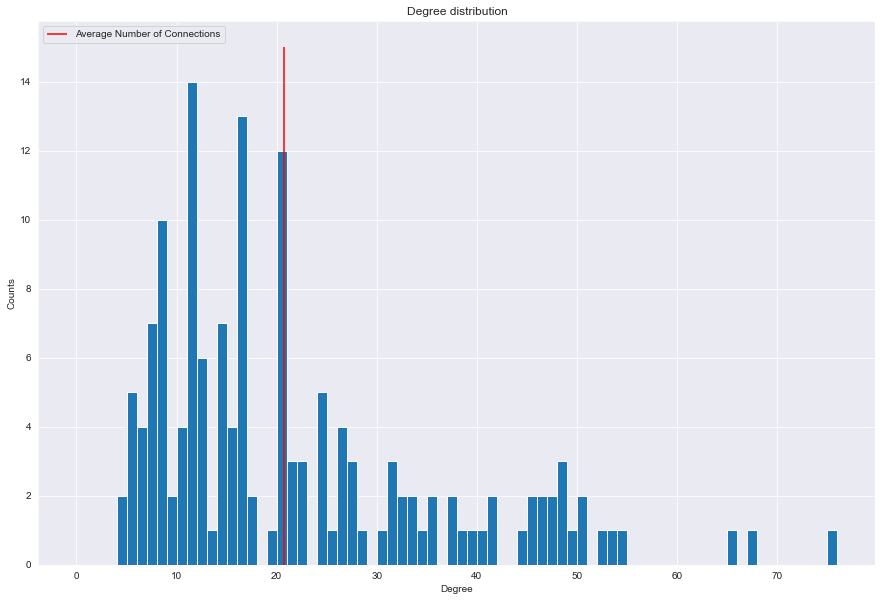

In [262]:
# On average each mafioso has 21 connections within the extended group, but six have fifty or more connections

fig, ax = plt.subplots(figsize = (15,10))
plt.hist([list(dict(G.degree()).values())],
         bins = np.linspace(0, 76, 77), stacked = False)
plt.vlines(20.7564, 0, 15, color = 'red')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.legend(['Average Number of Connections'], prop={'size': 10},
           loc='upper left')
plt.title('Degree distribution')
plt.savefig('degree_histogram.png')

In [19]:
#find the best connected mafiosi, with more than fifty connections each

top_six_degree = sorted(dict(G.degree()).items(), key = lambda x : x[1], reverse = True)[:6]
top_six_degree

[('Alessandro MANNO', 75),
 ('Antonino LAMARMORE', 67),
 ('Pietro Francesco PANETTA', 65),
 ('Cosimo Raffaele MAGNOLI', 54),
 ('Cosimo BARRANCA', 53),
 ('Francesco MUIÀ', 52)]

**SECOND INDICATOR - CLUSTERING COEFFICIENTS**

- The clustering coefficient measures the extent to which the nodes tend to cluster together. 
- If a mafiosi's close associates are all linked, then he will have a high clustering coefficient.
- A better connected node will often have a lower clustering coefficient, as having many connections makes it less likely that all the connections will be linked to each other.
- When we plot the distribution of the clustering coefficients, we'll see that most nodes have a high coefficient. 
- However a few of them do not, and these guys might have significance within the network. 

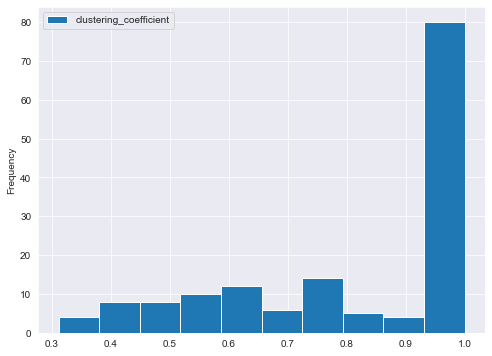

In [269]:
# form dataframe out of the clustering coefficients for each mafiosi
#visualise the distribution of the clustering coefficients
#most nodes have a high clustering coefficient
#it would be interesting to look at the few guys with the lower clustering coefficients

clustering = nx.clustering(G)
clustering_df = pd.DataFrame(clustering, columns = clustering.keys(), index = range(1))
clustering_df = clustering_df.T.rename(columns = {0: 'clustering_coefficient'})
fig, ax = plt.subplots(figsize = (8, 6))
clustering_df.plot(kind = 'hist', ax = ax)
plt.savefig('clustering.png')

In [21]:
# the mafiosi with the lowest clustering coefficients are the same ones who have the most degrees

bottom_six_clustering = list(clustering_df.sort_values(by = 'clustering_coefficient')[:6].index)
bottom_six_clustering

['Pietro Francesco PANETTA',
 'Cosimo BARRANCA',
 'Alessandro MANNO',
 'Cosimo Raffaele MAGNOLI',
 'Francesco MUIÀ',
 'Antonino LAMARMORE']

**THIRD INDICATOR - NODE CENTRALITY**

- It is striking that the same six names have emerged from the degree distribution and the clustering coefficients. It looks like they are all connected to many other mafiosi, who in turn are not all connected to each other. These six are the major hubs.
- Another indicator to consider is how central each node is, as expressed by 'Betweenness Centrality'. This looks at how many of the 'shortest paths' between other nodes pass through a particular node.
- When we plot the distribution of 'Betweenness Centrality' for the network, we find that most mafiosi score low on this metric.
- A few mafiosi have high scores, and are likely to be influential.

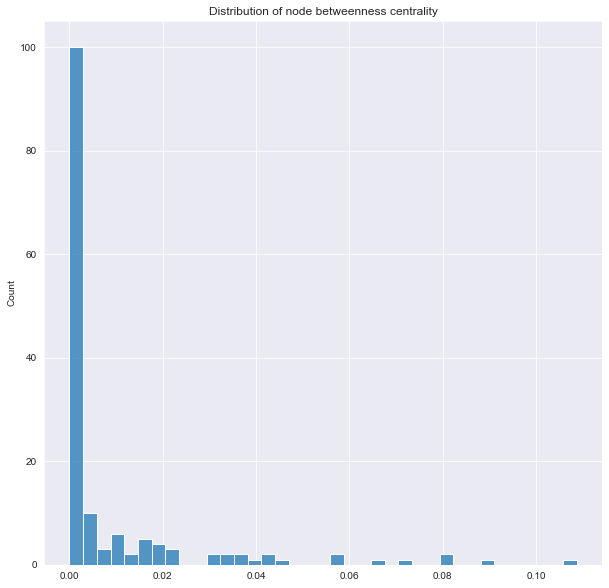

In [264]:
#visualise the distribution of 'Betweenness Centrality' in the network

node_centrality = nx.betweenness_centrality(G)
fig, ax = plt.subplots(figsize = (10,10))
sns.histplot(node_centrality.values(), ax = ax, legend = False)
plt.title('Distribution of node betweenness centrality')
plt.savefig('betweenness.png')

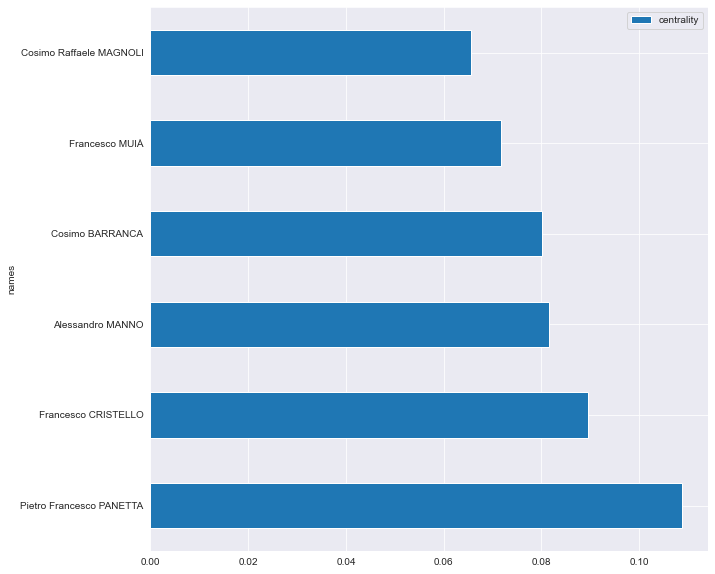

In [23]:
# most nodes/mafiosi have low scores, a handful have high scores - who are they?

six_nodes = sorted(node_centrality.items(), key = lambda x: x[1], reverse = True)[:6]
node_centrality_df = pd.DataFrame(six_nodes, columns = ['names', 'centrality']).set_index('names')
fig, ax = plt.subplots(figsize = (10,10))
node_centrality_df.plot(kind = 'barh', ax = ax)
plt.show()

**EXAMINE EDGES AS WELL AS NODES**
- Scoring the top six mafiosi for Betweenness Centrality, we see five names that we already recognise.
- There is one new name, Francesco Cristello, giving us a list of seven in total.
- Pietro Francesco PANETTA, Francesco CRISTELLO, Alessandro MANNO, Cosimo BARRANCA, Francesco MUIA, Cosimo Raffaele MAGNOLI, and Antonino LAMARMORE.
- We've looked at the nodes, now it would be intersting to see which edges are the most important. 
- There are a couple of metrics that we can consider: Edge Weights indicate how many times a particular connection has been made, and 'Edge Betweenness Centrality' is analogous to 'Node Betweenness Centrality', indicating the percentage of shortest paths that pass though a specific edge.


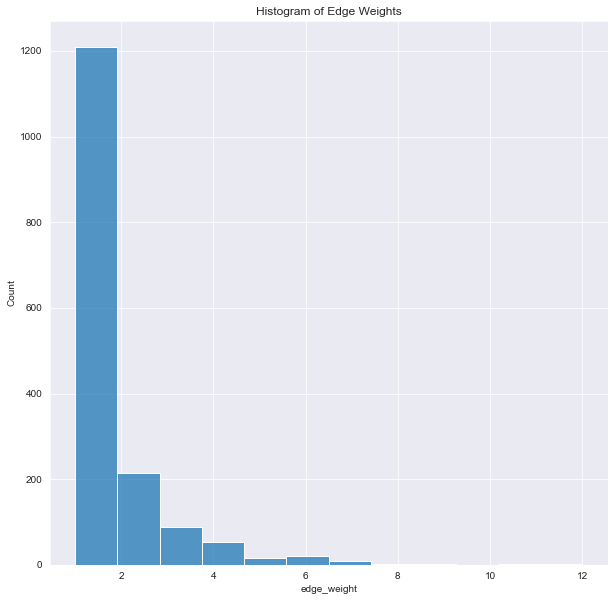

In [24]:
# visualise the distribution of edge weights throughout the network

edge_weights = [e[2]['weight'] for e in G.edges(data=True)]
fig, ax = plt.subplots(figsize = (10,10))
sns.histplot(edge_weights, ax = ax, bins = 12)
plt.xlabel('edge_weight')
plt.title('Histogram of Edge Weights')
plt.show()

In [25]:
# most edge weights are low, the few edges that are more significant all involve at least one name that we already recognise

biggest_edge_weights = sorted(list(G.edges(data=True)), key = lambda x: x[2]['weight'], reverse = True)
biggest_edge_weights[:10]

[('Cosimo Raffaele MAGNOLI', 'Pietro Francesco PANETTA', {'weight': 12}),
 ('Antonino LAMARMORE', 'Alessandro MANNO', {'weight': 11}),
 ('Nicola LUCA', 'Pietro Francesco PANETTA', {'weight': 11}),
 ('Antonino LAMARMORE', 'Stefano SANFILIPPO', {'weight': 9}),
 ('Alessandro MANNO', 'Stefano SANFILIPPO', {'weight': 9}),
 ('Cosimo BARRANCA', 'Giuseppe SALVATORE', {'weight': 8}),
 ('Emanuele DE CASTRO', 'Antonino LAMARMORE', {'weight': 8}),
 ('Cosimo Raffaele MAGNOLI', 'Giuffrido TAGLIAVIA', {'weight': 8}),
 ('Rocco ASCONE', 'Francesco MUIÀ', {'weight': 7}),
 ('Pietro CICHELLO', 'Stefano SANFILIPPO', {'weight': 7})]

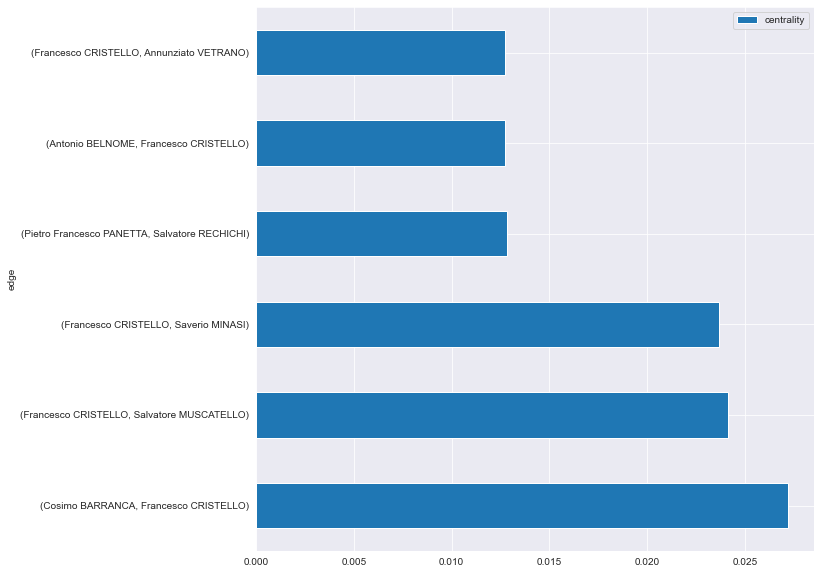

In [26]:
#visualize 'Edge Betweenness Centrality' for the network.
#all the significant edges involve at least one name that we already recognise.

edge_centrality = nx.edge_betweenness_centrality(G)
six_edges = sorted(edge_centrality.items(), key = lambda x: x[1], reverse = True)[:6]
edge_centrality_df = pd.DataFrame(six_edges, columns = ['edge', 'centrality'])
edge_centrality_df = edge_centrality_df.set_index('edge')
fig, ax = plt.subplots(figsize = (10,10))
edge_centrality_df.plot(kind = 'barh', ax = ax)
plt.show()

**WHO ARE THE SEVEN FIGURES IDENTIFIED BY NETWORK ANALYSIS?**

- Alessandro MANNO: 
Originally from Calabria, moved to Lombardy in the 1980s. From 2008 was head of the 'Locale di Pioltello', or boss of the Ndrangheta in the Milanese district of Pioltello. Following Operation Infinite he would be sentenced to sixteen years.
- Cosimo BARRANCA: 
Like Manno, Barranca moved to Lombardy in the 1980s. Thought to be the boss of the Ndrangheta in central Milan, sentenced to 14 years following Operation Infinite.
- Antonino LAMARMORE: 
An 'Infinito', the highest rank of the Ndrangeta in Lombardy. Boss of the Ndrangheta in Limbiate, a district of Milan. 
- Pietro Francesco PANETTA: 
Head of the Ndrangheta in the Milan district of Cormano, and a member of the Provincia ruling council. In 2008 he came into conflict with Carmelo Novella, the secessionist leader of the Ndranghetain Lombardy. Novella was killed in July 2008.
- Cosimo Raffaele MAGNOLI: 
PANETTA's deputy in Cormano.
- Francesco MUIÀ: 
Head of the Ndrangeta on the Ionian coast, sentenced to 24 years in 2016. Released three years later on grounds of ill health, aged 79.
- Francesco Cristello: 
Originally from San Giovanni Mileto in Calabria, sentenced to life imprisonment in 2019 for his part in the 2010 murder of the mafioso Rocco Stagno.



**VISUALISING SEVEN IMPORTANT MAFIOSI IN THE NETWORK**
- When we visualise the network below, we can see that of the seven mafiosi Francesco Cristello is the odd one out.
- The other six have many degrees and correspondingly low clustering coefficients, as well as acting as gatekeepers to less connected segments of the network.
- Cristello only performs the latter function (he has very high Betweenness Centrality because seven mafiosi have no connections except through him). If we had only examined Degrees and Clustering Coefficients then Cristello would not have featured.
- It may be that 'Betweenness Centrality' gives us a false impression of Cristello's importance, there is no information in the public domain to suggest he was a senior figure.

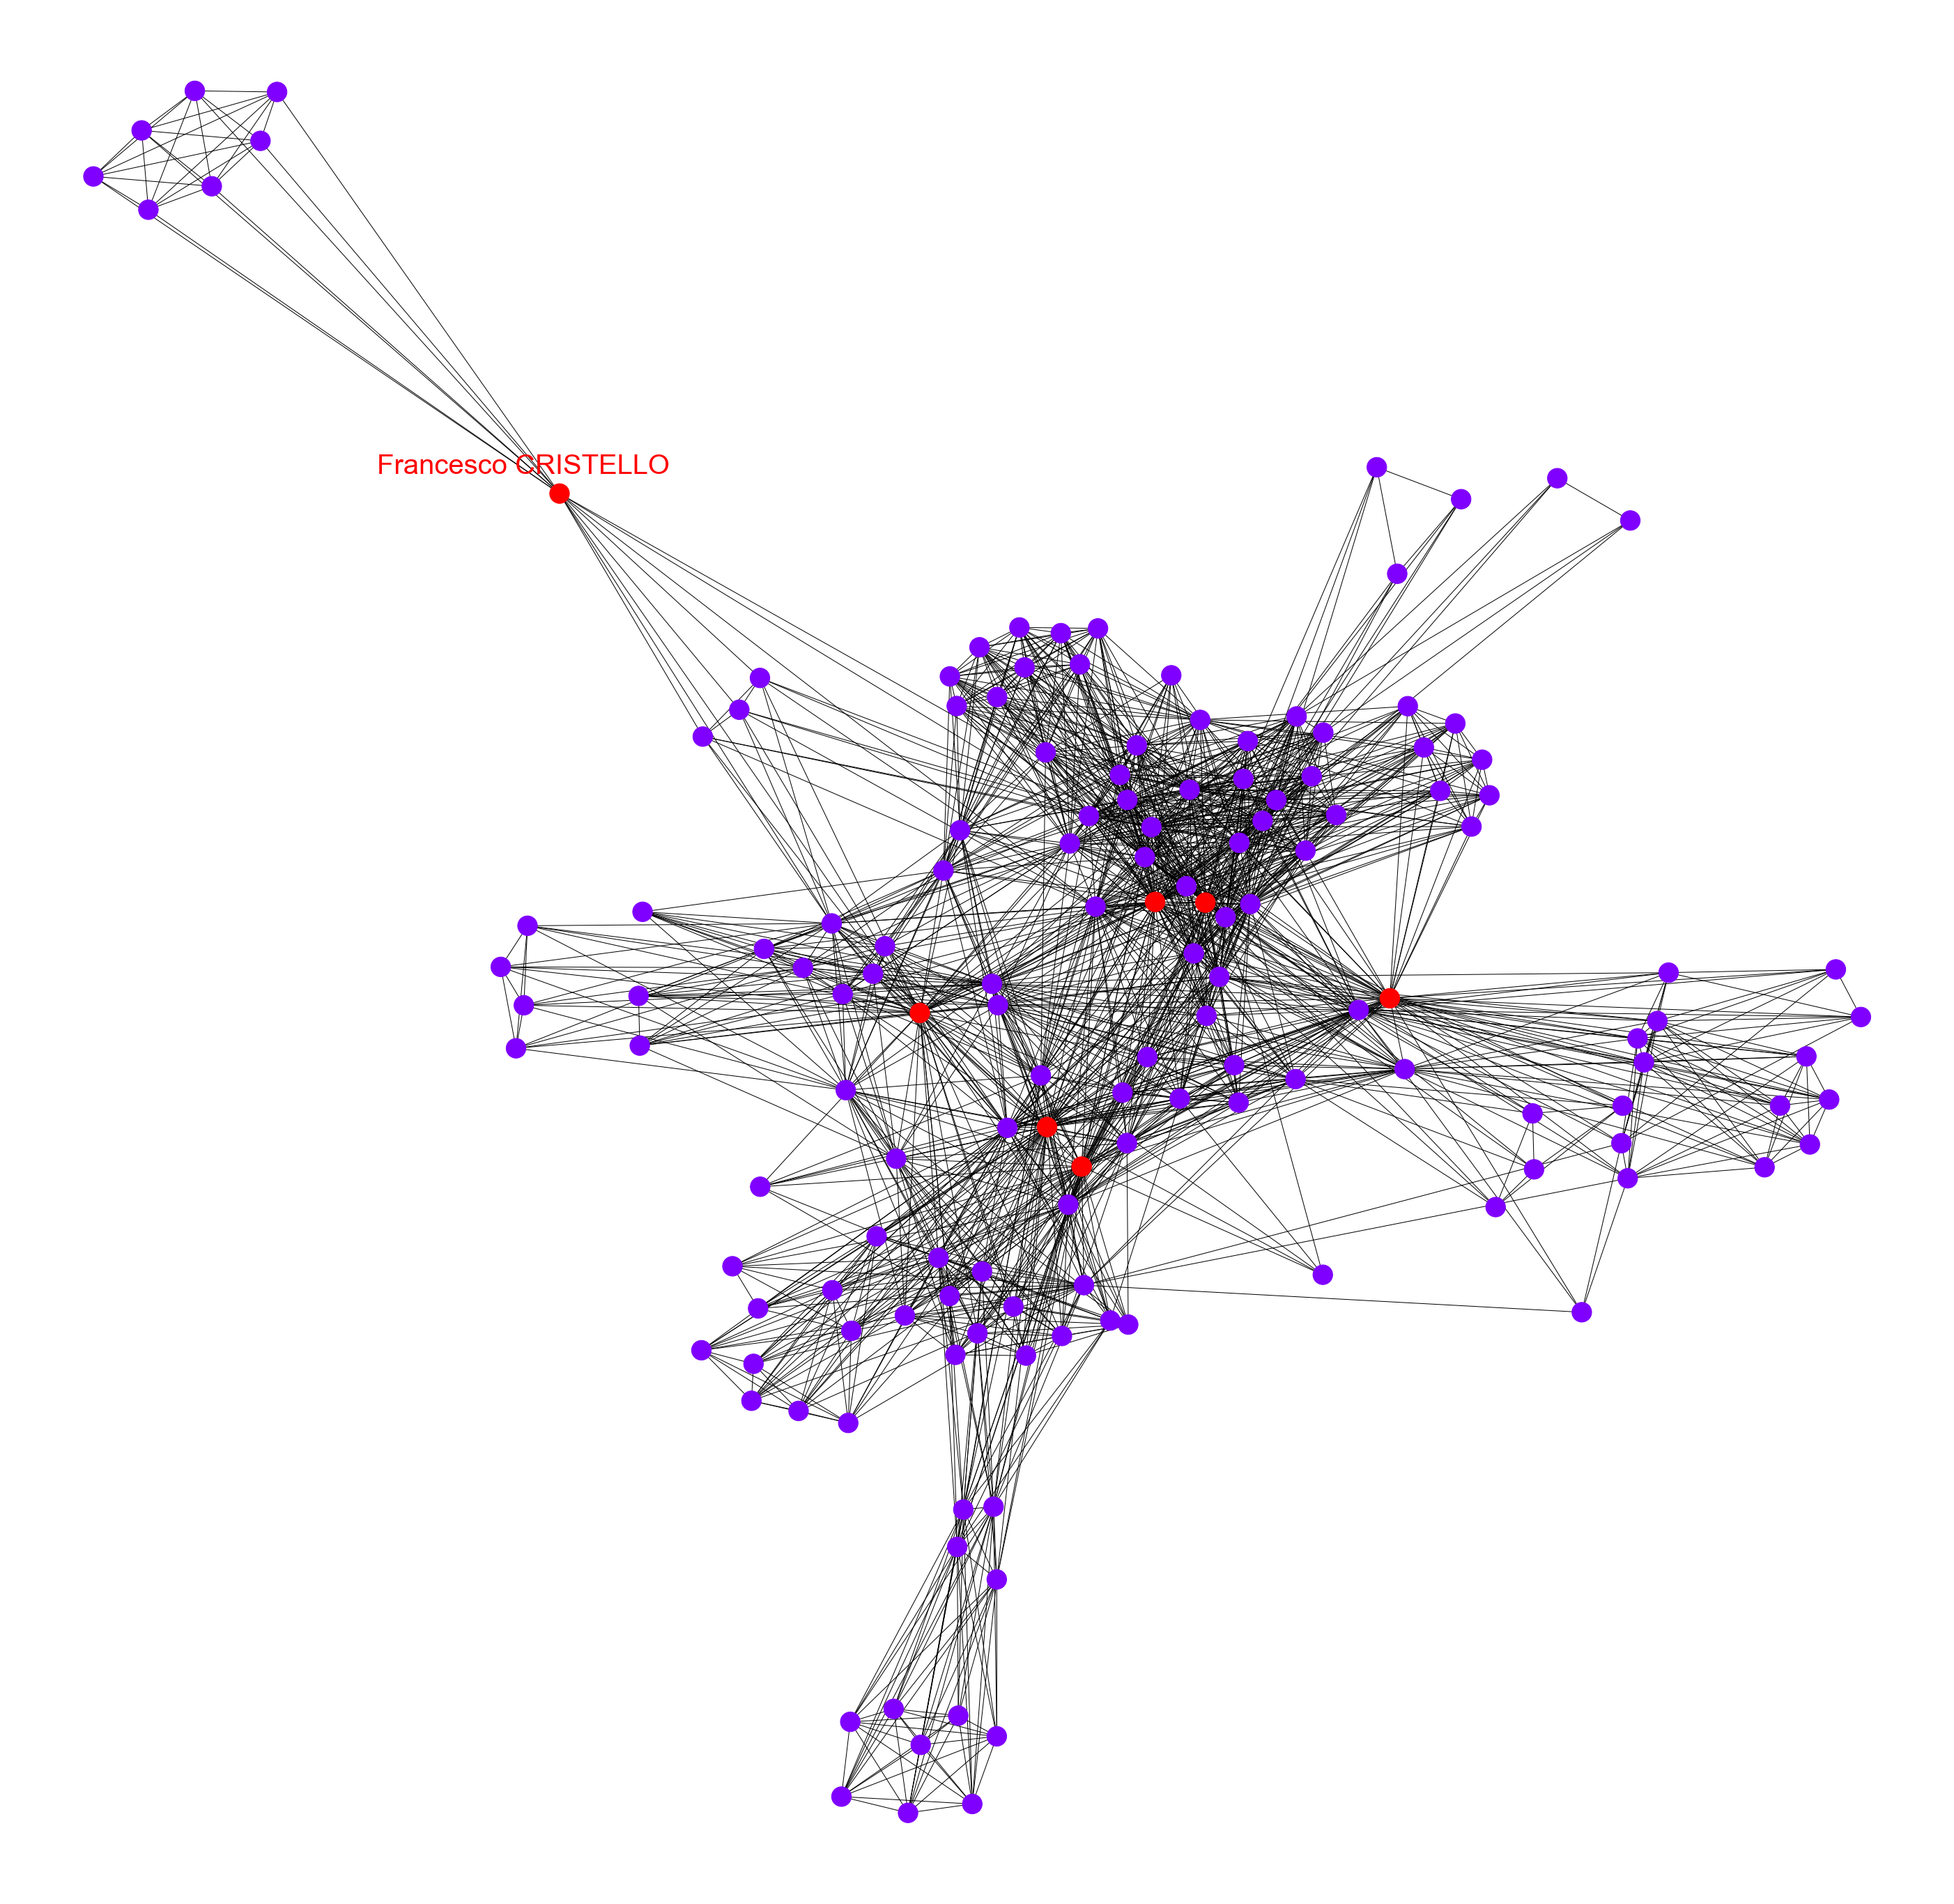

In [265]:
labels = {}    
for node in G.nodes():
    if node in 'Francesco CRISTELLO':
        #set the node name as the key and the label as its value 
        labels[node] = node

# visualise the positions of the seven key nodes within the network as a whole
top_degrees = [a for (a,b) in top_six_degree]
top_six_centrality = [a for a,b in six_nodes]
key_seven = set(top_six_centrality + top_degrees)
fig, ax = plt.subplots(figsize = (50,50))
position = nx.spring_layout(G, seed = 10)
position_higher = {}
for k, v in position.items():
    position_higher[k] = (v[0]-0.03, v[1]+0.03)
label_list = [1 if node in key_seven else 0 for node in dict(G.nodes.data()).keys()]
nx.draw(G, pos = position, with_labels = False, ax = ax, font_size = 90, node_color = label_list, cmap='rainbow', node_size = 800)
nx.draw_networkx_labels(G, position_higher, labels = labels,font_size= 40,font_color='r', ax = ax)
plt.savefig('cristello.png')

In [194]:
label_list = [1 if node in top_degrees else 0 for node in list(G.nodes())]
sum(label_list)

6

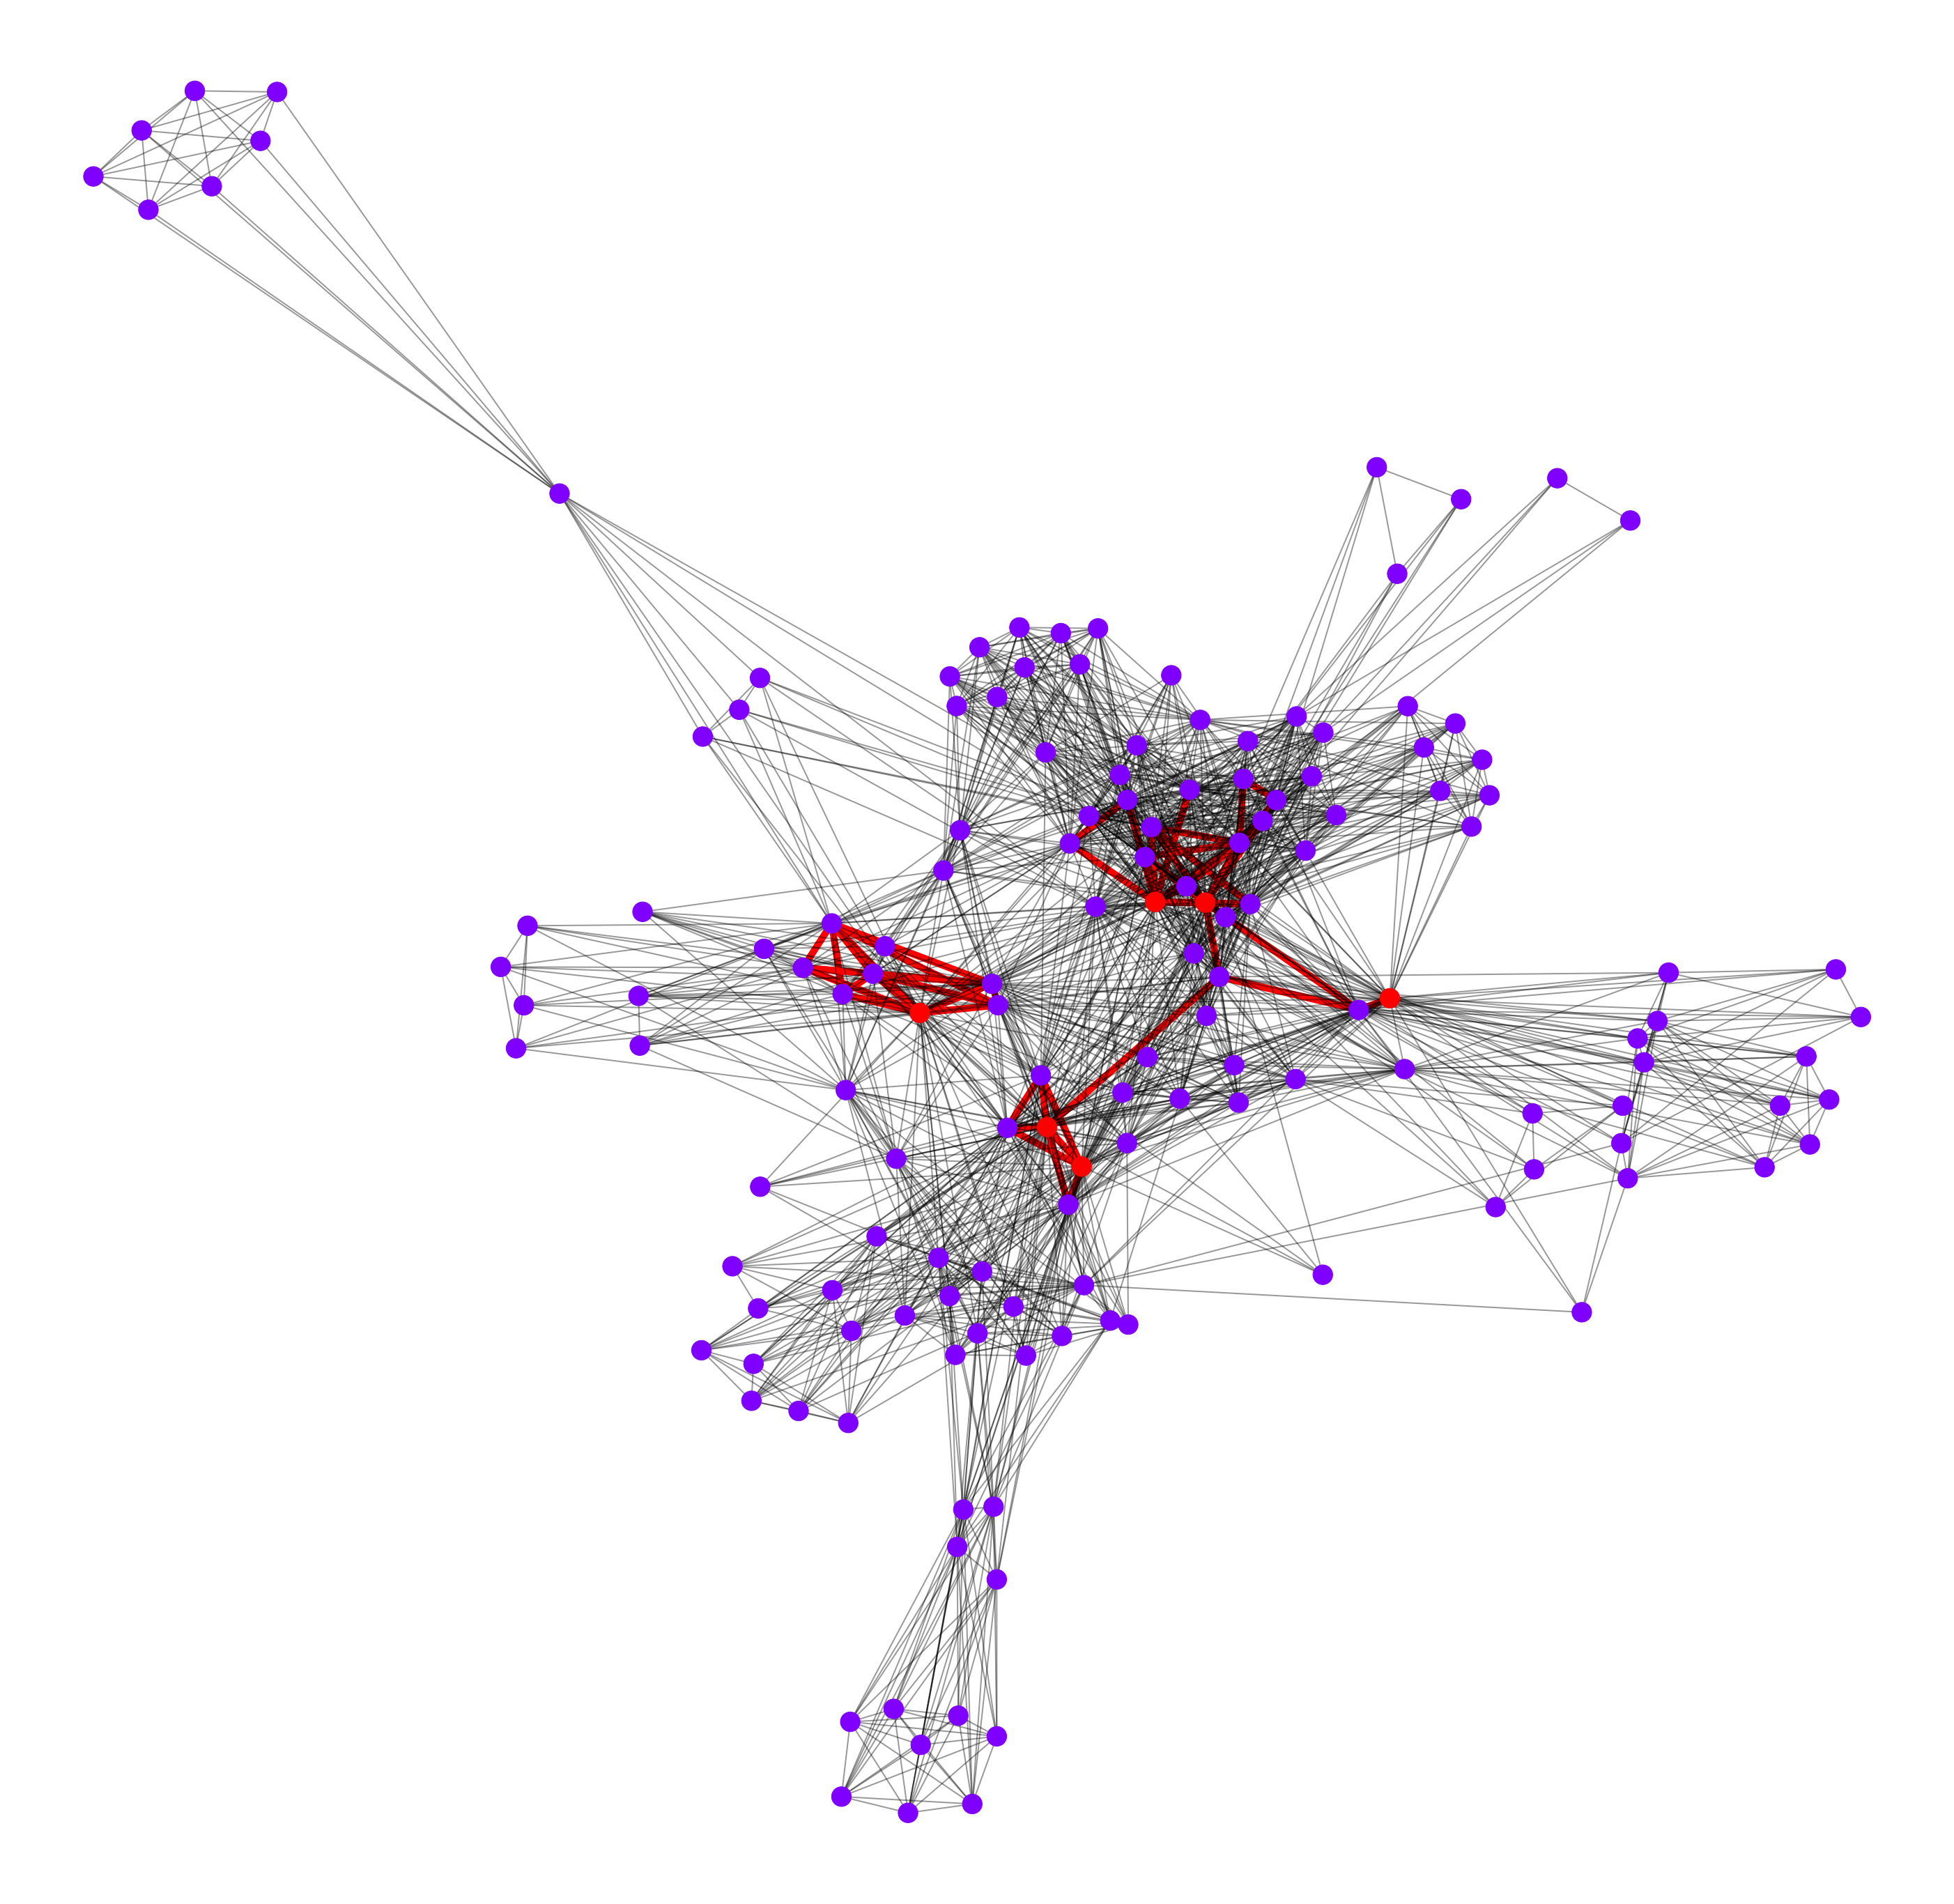

In [195]:
# visualise the top weighted edges (weight over 4) along with the six most connected mafiosi

fig, ax = plt.subplots(figsize = (50, 50))

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 4]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 4]

# positions for all nodes
pos = nx.spring_layout(G, seed = 10)  


label_list = [1 if node in top_degrees else 0 for node in list(G.nodes())]

# nodes
nx.draw_networkx_nodes(G, pos, node_size = 800, ax = ax, node_color = label_list, cmap='rainbow')

# edges
nx.draw_networkx_edges(G, pos, edgelist = elarge, width = 10, ax = ax, edge_color = 'red')
nx.draw_networkx_edges(G, pos, edgelist = esmall, width = 2, alpha=0.4, edge_color = "black", ax = ax)

plt.axis("off")
plt.show()

# PART 2: PREDICTIVE MODELLING

- It would be interesting to see if network analysis allows us to predict which members of the Ndrangheta are bosses. 
- Following Operation Infinito, the prosecutor in Milan assessed the status of various mafiosi, but it seems that this report has never been published in English. 
- Predictive modelling is impossible if we cannot assign a definite value to the target variable (status within the Ndrangheta).
- There may be a way round this problem, if we can find a proxy for the target variable.
- Of all the meetings in the dataset, one is clearly the most significant. The Summit of Paderno Dugnano was held at a meeting hall in piazza Falcone e Borsellino in Milan, ironically named after two anti-mafia magistrates who were murdered in the 1990s for their part in the 'Maxi-Trials' of 1986-7.
- The summit took place on October 31st 2009, and marked the election of Pasquale Zappia as the new Mastro Generale, charged with maintaining relations between the Ndrangheta based in Lombardy and their homeland in Calabria.
- Only senior figures would be invited to the summit. In the absence a definitive list of bosses, we can assume that the attendees of the Summit were the most senior members of the Ndrangheta in Lombardy. 
- This is not a perfect solution, as there were several attendees who remain unidentified. However it is likely a safe assumption that they do not come from within the dataset (or there probably would have been no headache with identifying them) - it is possible they were not local Ndrangheta from Lombardy, but visitors from Calabria.
- The challenge for the model: knowing who attended each meeting during the two years of surveillance, can we accurately predict who will be invited to the Summit at the end?
- The network analysis up to this point has included the Summit meeting. We will need to repeat this without the Summit meeting in the dataset, as it has become our target variable.

In [29]:
# list the mafiosi who attended summit of Paderno Dugnano

summit = mafia.loc[:,'31/10/2009']
in_attendence = summit[summit.values == 1]
attendence_df = mafia.loc[list(in_attendence.index), :]
attendees = attendence_df['names'].values
print('The mafiosi who attended the summit:', attendees)

The mafiosi who attended the summit: ['Rocco ASCONE' 'Arturo BALDASSARRE' 'Pio CANDELORO'
 'Leonardo Antonio CHIARELLA' 'Domenico Sandro COMMISSO'
 'Salvatore DE MARCO' 'Salvatore FERRARO' 'Giovanni FICARA'
 'Giuseppe FURCI' 'Antonino LAMARMORE' 'Nicola LUCA'
 'Cosimo Raffaele MAGNOLI' 'Vincenzo MANDALARI' 'Alessandro MANNO'
 'Annunziato Giuseppe MOSCATO' 'Francesco MUIÀ' 'Salvatore MUSCATELLO'
 'Giuseppe Antonio NERI' 'Pietro Francesco PANETTA'
 'Pasquale Emilio SARCINA' 'Giuffrido TAGLIAVIA' 'Luigi VONA'
 'Pasquale ZAPPIA']


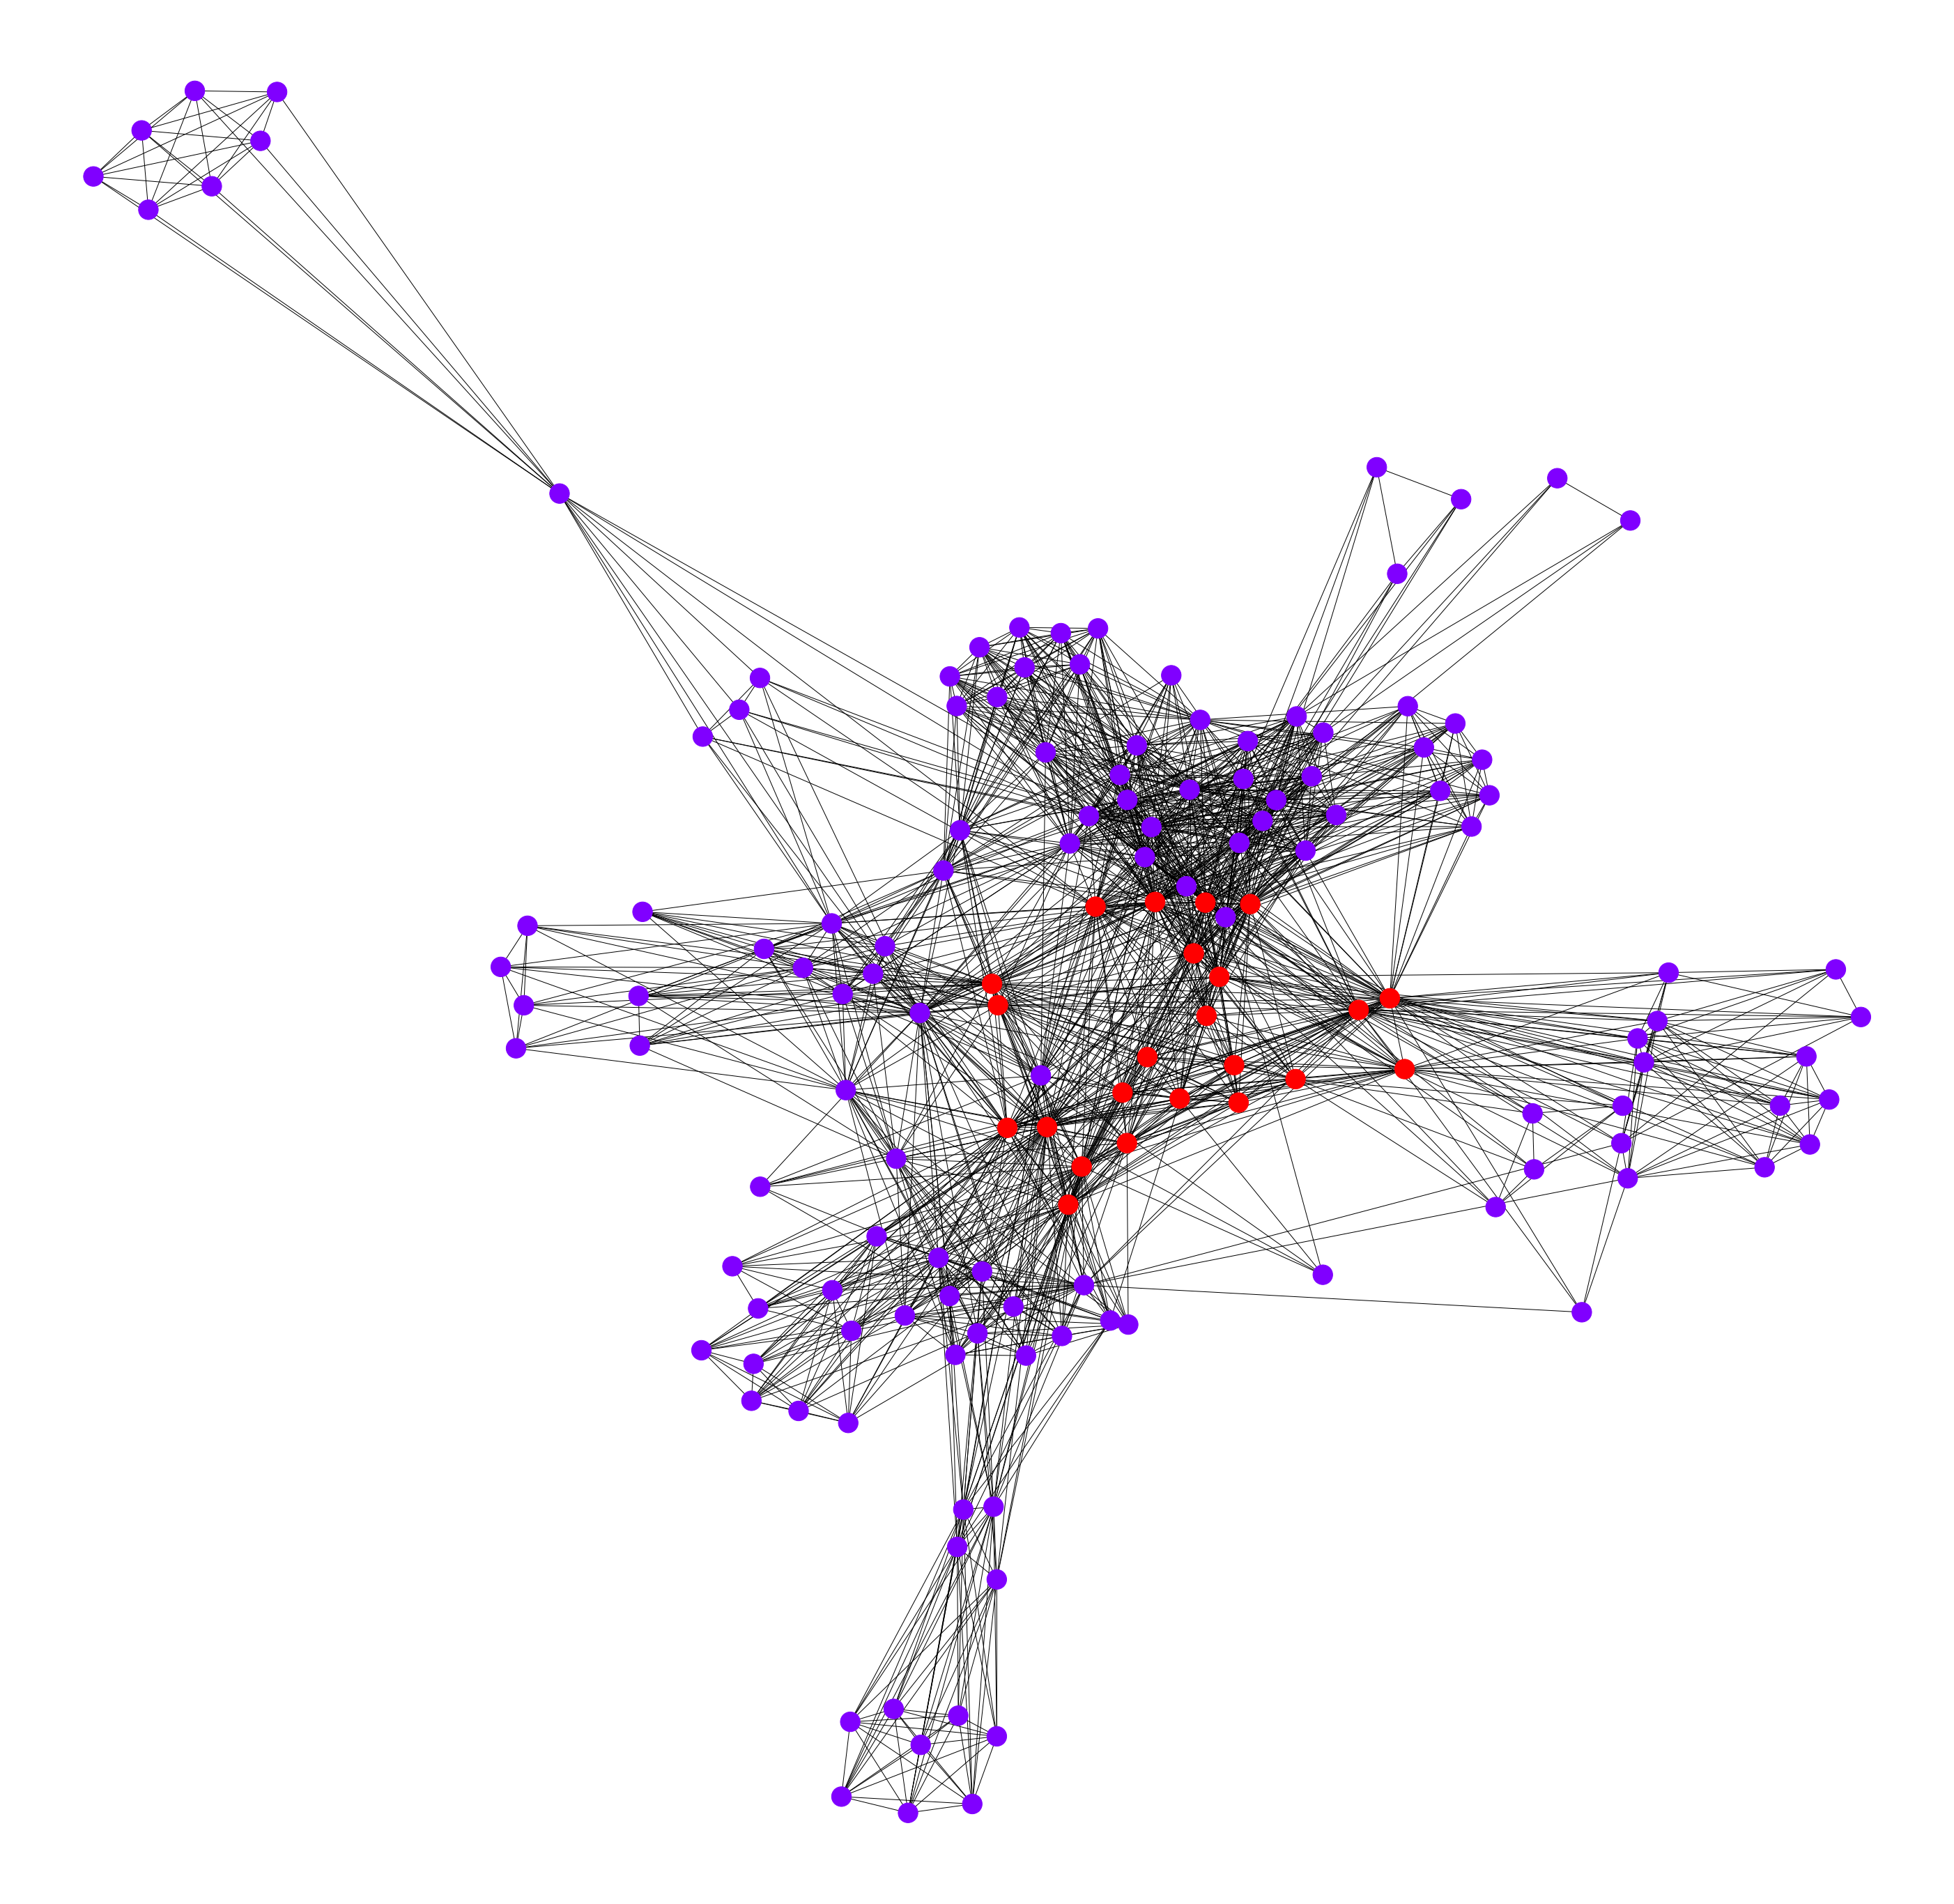

In [266]:
# visualise the positions of the attendees within the network as a whole

fig, ax = plt.subplots(figsize = (50,50))
position = nx.spring_layout(G, seed = 10)
label_list = [1 if node in attendees else 0 for node in dict(G.nodes.data()).keys()]
nx.draw(G, pos = position, with_labels = False, ax = ax, font_size = 90, node_color = label_list, cmap='rainbow', node_size = 800)
plt.savefig('attendees.png')

**REMOVING THE SUMMIT MEETING FROM THE DATASET**

We can see from the visualisation that the summit attendees are generally central and well connected figures within the network, which would go to support the idea that they are senior. 

To move on to predictive modelling, we will first need to remove the summit from the original dataset, and re-caclulate all the key metrics in NetworkX without it - otherwise information from our target variable will 'leak' into our predictor variables.


In [31]:
# drop the summit from the dataset, set a new index and transpose the dataframe

mafia_shortened = mafia.drop(columns = ['31/10/2009']).set_index('names')
mafia_shortened_copy = mafia_shortened.T


#create lists of attendees for each meeting and collect in dictionary
meetings_shortened = defaultdict(list)
for index, row in mafia_shortened_copy.iterrows():
    for col in list(mafia_shortened_copy.columns):
        if mafia_shortened_copy.loc[index,col] == 1:
            meetings_shortened[index].append(col)
            
            
#create list of network edges from lists of attendees      
edges_list_shortened = []
for k, v in meetings_shortened.items():
    edges_shortened = list(combinations(v,2))
    edges_list_shortened.append(edges_shortened)

    
#flatten the list of lists and assemble in a dataframe
flat_edges_list_shortened = [item for sublist in edges_list_shortened for item in sublist]
edges_df_shortened = pd.DataFrame(flat_edges_list_shortened, columns = ['source', 'target'])


# #add weights to each edge, based on how often each mafiosi 'pairing' occured
weighted_edges_df_shortened = pd.DataFrame(edges_df_shortened.groupby(['source', 'target']).size().reset_index())
weighted_edges_df_shortened = weighted_edges_df_shortened.rename(columns = {0: 'weight'})
weighted_edges_df_shortened.head()

# #to create a dataframe of nodes with 'family_size' attribute, we will need to first create a dictionary to map the 'family_size' onto each surname
family_sizes_shortened = mafia_shortened.groupby('surnames').size()
size_dict_shortened = defaultdict(int)
for name, size in family_sizes_shortened.items():
    size_dict_shortened[name] = size

# # put mafiosi names into dataframe and add 'family_size' attribute
nodes_df_shortened = pd.DataFrame({'name': mafia_shortened.index, 'surname': mafia_shortened['surnames']})
nodes_df_shortened['family_size'] = nodes_df_shortened['surname'].map(size_dict_shortened)
nodes_df_shortened = nodes_df_shortened.reset_index(drop = True)

# # construct new network 'G_shortened' from the reduced dataset (excluding the summit)

G_shortened = nx.Graph()

for i, name in enumerate(nodes_df_shortened['name'].values):
    G_shortened.add_node(name, family_size = nodes_df_shortened.loc[i, 'family_size'], family_name = nodes_df_shortened.loc[i, 'surname'])
    
for i, row in weighted_edges_df_shortened.iterrows():
    G_shortened.add_edge(row['source'], row['target'], weight = row['weight'])


In [32]:
# the reduced network has the same number of nodes (mafiosi), but since the biggest meeting has been dropped the number of connections has gone down, along with average degree

print(nx.info(G_shortened)), print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 151
Number of edges: 1443
Average degree:  19.1126
Name: 
Type: Graph
Number of nodes: 151
Number of edges: 1619
Average degree:  21.4437


(None, None)

**PREPARING THE FINAL DATAFRAME**

- Now we have a new network without the Summit meeting, we can prepare the final dataframe for predictive modelling.
- It will include the information derived from NetworkX, as well as the categorical features from the original dataframe, and a feature for the total number of summits attended by each mafioso.

In [33]:
# remove surnames (to be restored later), create a new column for total number of summits attended by each mafiosi

df = mafia_shortened
surnames = df['surnames']
df = df.drop(columns = ['Unnamed: 0', 'first_names', 'surnames']).reset_index(drop = True)
df['total_attended'] = df.sum(axis = 1)


# create a copy of the dataframe and add those features derived from NetworkX analysis
node_centrality_shortened = nx.betweenness_centrality(G_shortened)
clustering_shortened = nx.clustering(G_shortened)
df_final = df.copy()
df_final['node_centrality'] = list(node_centrality_shortened.values())
df_final['clustering'] = list(clustering_shortened.values())
df_final['degree'] = list(dict(G_shortened.degree()).values())
df_final['surname'] = surnames.values


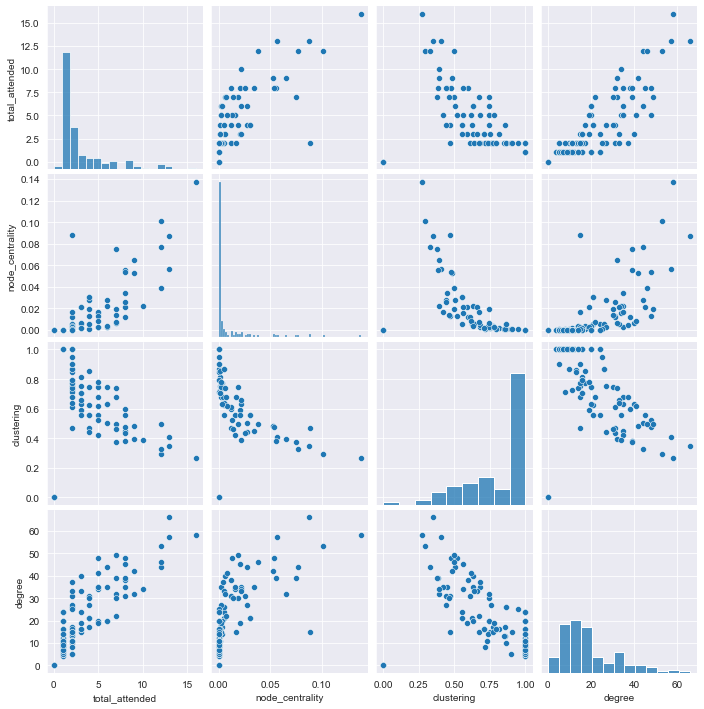

In [34]:
#visualise the relationship of numeric columns

numeric_cols = ['total_attended', 'node_centrality', 'clustering', 'degree']
sns.pairplot(df_final, vars = numeric_cols)
plt.show()

**CHECKING FOR OUTLIERS**

- Now we have removed the Summit meeting, we can see that not every mafiosi has attended at least one of the other meetings (ie for at least one of them, the Summit was the only meeting they attended).
- We need to examine these outliers to determine if they really were senior mafiosi.

In [35]:
df_final[df_final['total_attended'] == 0]

18/10/2007(L)  29/11/2007(L)  02/02/2008(L)  15/02/2008(1)  15/02/2008(2)  \
6               0              0              0              0              0   
49              0              0              0              0              0   

    21/02/2008(L)  26/02/2008  01/03/2008  12/03/2008(L)  23/04/2008  ...  \
6               0           0           0              0           0  ...   
49              0           0           0              0           0  ...   

    11/07/2009  24/07/2009(L)  03/08/2009(L)  16/09/2009  02/10/2009  \
6            0              0              0           0           0   
49           0              0              0           0           0   

    total_attended  node_centrality  clustering  degree      surname  
6                0              0.0         0.0       0  BALDASSARRE  
49               0              0.0         0.0       0        FURCI  

[2 rows x 51 columns]

In [36]:
mafia.loc[[6,49], :]

Unnamed: 0  18/10/2007(L)  29/11/2007(L)  02/02/2008(L)  \
6   BALDASSARRE Arturo              0              0              0   
49      FURCI Giuseppe              0              0              0   

    15/02/2008(1)  15/02/2008(2)  21/02/2008(L)  26/02/2008  01/03/2008  \
6               0              0              0           0           0   
49              0              0              0           0           0   

    12/03/2008(L)  ...  26/06/2009(L)  11/07/2009  24/07/2009(L)  \
6               0  ...              0           0              0   
49              0  ...              0           0              0   

    03/08/2009(L)  16/09/2009  02/10/2009  31/10/2009     surnames  \
6               0           0           0           1  BALDASSARRE   
49              0           0           0           1        FURCI   

    first_names               names  
6        Arturo  Arturo BALDASSARRE  
49     Giuseppe      Giuseppe FURCI  

[2 rows x 51 columns]

**BALDASSARRE AND FURCI**

- Very little information seems to have been published about Giuseppe Furci, it seems unlikely that he is/was a boss. His presence at the Summit is a mystery.
-  Arturo Baldassarre was a councilor in Paderno Dugnano, and Vice President of the Management Committee of the Center for the Elderly "Falcone e Borsellino", the building where the Summit took place. He seems to be a corrupt local official rather than a major player in the Ndragheta, his attendance was contingent on location rather than seniority.
- On that basis, we will drop Baldassarre and Furci from the dataset, as the goal is to predict seniority.

In [41]:
#drop the rows for Arturo Baldassarre and Guiseppe Furci

df_final = df_final.drop([6, 49])


# our target variable is the column '31/10/2009' from the original mafia dataframe
# to ensure it's the correct length, we have to drop the entries corresponding to Baldassarre and Furci

final_copy = mafia.copy()


# Baldassarre is row 6, Furci is row 49
final_copy = final_copy.drop([6, 49]).reset_index(drop = True)


#separate the target variable
target = final_copy['31/10/2009']


#separate predictor variables and target variables
y = target
X = df_final


# baseline is 85%
y.value_counts(normalize = True)


0    0.85906
1    0.14094
Name: 31/10/2009, dtype: float64

In [44]:
#create pipeline - polynomial features, standard scaler, logistic regression model

for col in X.columns:
    if col not in numeric_cols:
        X[col] = X[col].astype('category')

X_dummies = pd.get_dummies(X, drop_first = True)


#separate out the categorical and continuous columns for different pre-processing
cat_cols = [col for col in list(X_dummies.columns) if col not in numeric_cols]


# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y,
                        stratify = y, test_size = 0.2, random_state = 1)


#set up pipeline including column transformer

ss = StandardScaler()
lr = LogisticRegression()
pf = PolynomialFeatures(degree = 3)
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_lr = Pipeline(steps=[('column_transformer', col_trans), ('standard_scaler', ss), ('log_reg', lr)])


#grid of parameters for logistic regression model
params = {'log_reg__C': np.logspace(-5, 5, 15),
          'log_reg__fit_intercept': [True, False],
         'log_reg__class_weight': ['balanced', None]}

gs_lr = GridSearchCV(estimator= pipe_lr,
                  param_grid = params,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('continuous',
                                                                         PolynomialFeatures(degree=3),
                                                                         ['total_attended',
                                                                          'node_centrality',
                                                                          'clustering',
                                                                          'degree'])])),
                                       ('standard_scaler', StandardScaler()),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-2,
             param_grid={'log_reg__C': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-

In [45]:
# check for cross_validated score on training set
print('gs_lr best_score:', gs_lr.best_score_, 'gs_lr best_params:', gs_lr.best_params_)

gs_lr best_score: 0.8905797101449275 gs_lr best_params: {'log_reg__C': 0.037275937203149416, 'log_reg__class_weight': None, 'log_reg__fit_intercept': True}


In [109]:
# check performance on test set
predictions = gs_lr.predict(X_test)
print('test_accuracy:', accuracy_score(y_test, predictions))
print('test_recall:', recall_score(y_test, predictions))
print('test_f1:', f1_score(y_test, predictions))

test_accuracy: 0.8666666666666667
test_recall: 0.5
test_f1: 0.5


**CHECK HOW MUCH IMPACT NETWORK ANALYSIS HAS HAD ON PREDICTIONS**
- So far we have made predictions on a dataset that includes categorical features (attendence at specific meetings, and family names), a continuous feature based on them (total meetings attended) and continuous features derived from NetworkX (degree, clustering coefficient, betweenness centrality).
- If we remove this last group, we can see what value if any the Network Analysis added to our ability to make predictions.

In [111]:
# create a new dataframe without the features generated by NetworkX

df_final_reduced = df_final.drop(columns = ['node_centrality', 'clustering', 'degree'])

#separate the target variable
target = final_copy['31/10/2009']


#separate predictor variables and target variables
y = target
X_reduced = df_final_reduced


# dummify categorical variables
X_dummies_2 = pd.get_dummies(X_reduced, drop_first = True)


# split data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_dummies_2, y,
                        stratify = y, test_size=0.2, random_state = 1)



# create pipeline, SVC model

pf = PolynomialFeatures(degree = 3)
col_trans = ColumnTransformer([('continuous', pf, [0])], remainder = 'passthrough')
ss = StandardScaler()
lr = LogisticRegression()
pipe_lr_reduced = Pipeline(steps=[('column_transformer', col_trans), ('standard_scaler', ss), ('log_reg', lr)])


#grid of parameters for logistic regression model
params = {'log_reg__C': np.logspace(-5, 5, 15),
          'log_reg__fit_intercept': [True, False],
         'log_reg__class_weight': ['balanced', None]}

gs_lr_reduced = GridSearchCV(estimator= pipe_lr_reduced,
                  param_grid = params,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_lr_reduced.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('continuous',
                                                                         PolynomialFeatures(degree=3),
                                                                         [0])])),
                                       ('standard_scaler', StandardScaler()),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-2,
             param_grid={'log_reg__C': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05]),
                         'log_reg__class_weight': ['balanced', None],
       

In [121]:
# check for cross_validated score on training set - it shows a significant decline
print('gs_lr reduced best_score:', gs_lr.best_score_)
print('gs_lr_reduced best score:', gs_lr_reduced.best_score_)

gs_lr best_score: 0.8905797101449275
gs_lr_reduced best score: 0.8655797101449275


In [113]:
predictions_reduced = gs_lr_reduced.predict(X_test_2)
print('test_accuracy (without NetworkX features):', accuracy_score(y_test_2, predictions_reduced))
print('test_recall (without NetworkX features):', recall_score(y_test_2, predictions_reduced))
print('test_f1 (without NetworkX features):', f1_score(y_test_2, predictions_reduced))

test_accuracy (without NetworkX features): 0.8666666666666667
test_recall (without NetworkX features): 0.0
test_f1 (without NetworkX features): 0.0


**TWEAKING THE THRESHHOLD**
- We can see that the features from NetworkX make a significant difference - not so much in the accuracy, but more in the Recall and F1 scores - without them, the model finds it very difficult to predict members of the minority class.
- On that basis, we will re-introduce the NetworkX features, and see if we can improve the model's scores.
- As the model is fighting against a class imbalance, it would be interesting to see if adjusting the threshold would help it.

In [88]:
# revert to the model that included NetworkX features - gs_lr
# Get the predicted probabilities and explicitly name the columns:

Y_pp = pd.DataFrame(gs_lr.predict_proba(X_test),
             columns=['class_0_pp', 'class_1_pp'])
Y_pp.head()

class_0_pp  class_1_pp
0    0.500565    0.499435
1    0.959653    0.040347
2    0.956275    0.043725
3    0.940294    0.059706
4    0.940955    0.059045

In [89]:
# define a function that allows for tweaking of the threshhold

def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

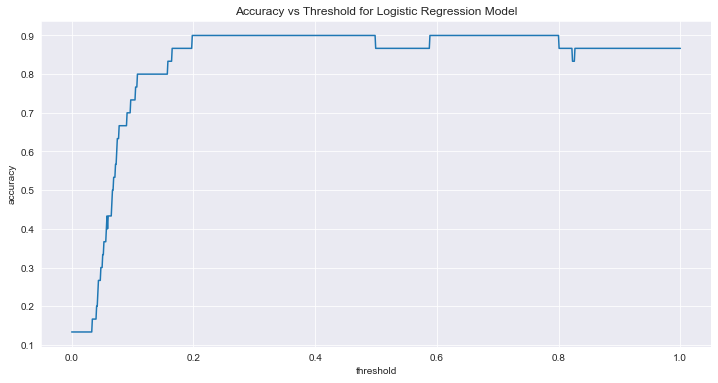

In [114]:
#plot accuracies vs thresholds

accuracies = np.array(
    [(i, accuracy_score(y_test, Y_pp.class_1_pp.apply(predict_at_threshold, threshold=i))) 
        for i in np.linspace(0, 1, 1000)])
plt.figure(figsize=(12, 6))
plt.plot(accuracies[:, 0], accuracies[:, 1])
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.title('Accuracy vs Threshold for Logistic Regression Model')
plt.show()

In [104]:
# find the best threshold and its corresponding accuracy level - by tweaking the threshold, we could get the test score up to 0.9 with the LR model

accuracies[accuracies[:, 1].argmax()]

array([0.1981982, 0.9      ])

In [136]:
# check other key metrics for predictions with imbalanced classes - ie Recall, F1

def scores_at_thresholds(probs):
    predictions = [probs.apply(predict_at_threshold, threshold=i) 
                   for i in np.linspace(0, 1, 1000)]
    scores = np.array(
    [(threshold, 
      accuracy_score(y_test, predictions[i]),
      recall_score(y_test, predictions[i]), 
      f1_score(y_test, predictions[i])) 
     for i, threshold in enumerate(np.linspace(0, 1, 1000))])
    return scores

scores = scores_at_thresholds(Y_pp.class_1_pp)

scores

array([[0.        , 0.13333333, 1.        , 0.23529412],
       [0.001001  , 0.13333333, 1.        , 0.23529412],
       [0.002002  , 0.13333333, 1.        , 0.23529412],
       ...,
       [0.997998  , 0.86666667, 0.        , 0.        ],
       [0.998999  , 0.86666667, 0.        , 0.        ],
       [1.        , 0.86666667, 0.        , 0.        ]])

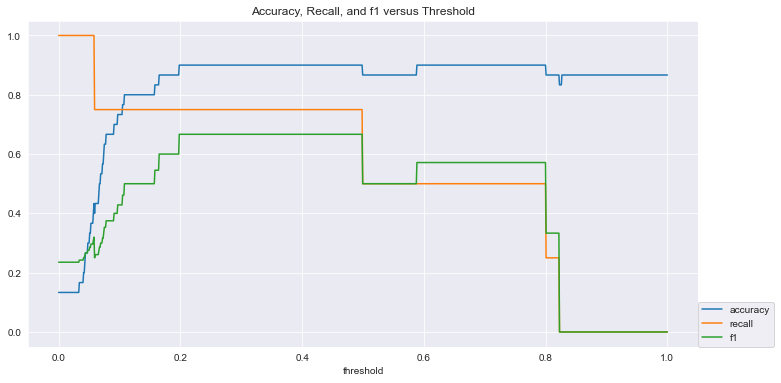

In [267]:
# we can see that a threshold of 0.2 provides the best overall performance
# accuracy of 0.9, recall slightly over 0.7, f1 slightly under 0.7

plt.figure(figsize=(12, 6))
plt.plot(scores[:, 0], scores[:, 1], label='accuracy')
plt.plot(scores[:, 0], scores[:, 2], label='recall')
plt.plot(scores[:, 0], scores[:, 3], label='f1')
plt.legend(loc=[1, 0])
plt.xlabel('threshold')
plt.title('Accuracy, Recall, and f1 versus Threshold')
plt.savefig('threshold.png')

In [139]:
# best performance at threshold 0.2, accuracy 0.9, recall 0.75, f1 0.66.
scores_1_df = pd.DataFrame(scores, columns = ['threshold', 'accuracy', 'recall', 'f1'])
scores_1_df[scores_1_df['threshold'] >= 0.2]

threshold  accuracy  recall        f1
200   0.200200  0.900000    0.75  0.666667
201   0.201201  0.900000    0.75  0.666667
202   0.202202  0.900000    0.75  0.666667
203   0.203203  0.900000    0.75  0.666667
204   0.204204  0.900000    0.75  0.666667
..         ...       ...     ...       ...
995   0.995996  0.866667    0.00  0.000000
996   0.996997  0.866667    0.00  0.000000
997   0.997998  0.866667    0.00  0.000000
998   0.998999  0.866667    0.00  0.000000
999   1.000000  0.866667    0.00  0.000000

[800 rows x 4 columns]

**ADDRESS CLASS IMBALANCE**

- The datset suffers from a class imbalance (just over twenty in the minority class, about 130 in the majority.
- We can address this by oversampling the minority, undersampling the majority, or both.
- Hopefully this will make it easier for the model to successfully predict members of the minority class, with the aim of improving Recall and F1 scores

In [117]:
# #set up pipeline including SMOTENC, column transformer and Logistic Regression model


# # split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y,
                        stratify = y, test_size = 0.2, random_state = 1)


# # #separate out the categorical and continuous columns for different pre-processing
cat_cols = [col for col in list(X_dummies.columns) if col not in numeric_cols]
cat_index = [True if col in cat_cols else False for col in X_train.columns]



smote_nc = SMOTENC(categorical_features = np.array(cat_index), random_state=0)
pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
lr = LogisticRegression()
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_lr_snc = Pipeline(steps=[('smotenc', smote_nc), ('column_transformer', col_trans), ('standard_scaler', ss), ('log_reg', lr)])


# #grid of parameters for logistic regression model

params = {'log_reg__C': np.logspace(-5, 5, 15),
          'log_reg__fit_intercept': [True, False],
         'log_reg__class_weight': ['balanced', None]}

gs_lr_SMOTE = GridSearchCV(estimator= pipe_lr_snc,
                  param_grid = params,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_lr_SMOTE.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smotenc',
                                        SMOTENC(categorical_features=array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,...
             param_grid={'log_reg__C': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05]),
                         'log_reg__class_weight': ['balanced', None],
                         'log_reg__fit_intercept': [True, False]},
             

In [122]:
# check for cross_val_score
gs_lr_SMOTE.best_score_

0.8405797101449275

In [125]:
# accuracy on test set remains the same as without SMOTE, but recall and F1 have both improved (ie we have seen a reduction in false negatives)
# SMOTE helps the model to accurately predict the minority class

predictions = gs_lr_SMOTE.predict(X_test)
print('test_accuracy (with SMOTE):', accuracy_score(y_test, predictions))
print('test_recall (with SMOTE):', recall_score(y_test, predictions))
print('test_f1 (with SMOTE):', f1_score(y_test, predictions))

test_accuracy (with SMOTE): 0.8666666666666667
test_recall (with SMOTE): 0.75
test_f1 (with SMOTE): 0.6


In [215]:
#UNDERSAMPLE MAJORITY CLASS AS WELL AS SMOTE ON MINORITY
# #set up pipeline including SMOTENC, column transformer and Logistic Regression model


# # split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y,
                        stratify = y, test_size = 0.2, random_state = 1)


# # #separate out the categorical and continuous columns for different pre-processing
cat_cols = [col for col in list(X_dummies.columns) if col not in numeric_cols]
cat_index = [True if col in cat_cols else False for col in X_train.columns]



smote_nc = SMOTENC(categorical_features = np.array(cat_index), random_state=0, sampling_strategy = 0.5)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)
pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
lr = LogisticRegression()
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_lr_snc_under = Pipeline(steps=[('smotenc', smote_nc), ('under', under), ('column_transformer', col_trans), ('standard_scaler', ss), ('log_reg', lr)])


# #grid of parameters for logistic regression model

params = {'log_reg__C': np.logspace(-5, 5, 15),
          'log_reg__fit_intercept': [True, False],
         'log_reg__class_weight': ['balanced', None]}

gs_lr_SMOTE_under = GridSearchCV(estimator= pipe_lr_snc_under,
                  param_grid = params,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_lr_SMOTE_under.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smotenc',
                                        SMOTENC(categorical_features=array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,...
             param_grid={'log_reg__C': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05]),
                         'log_reg__class_weight': ['balanced', None],
                         'log_reg__fit_intercept': [True, False]},
             

In [216]:
# check for cross_val_score
gs_lr_SMOTE_under.best_score_

0.8822463768115943

In [217]:
#combining Undersampling with SMOTE helps the accuracy slightly (cross_val and test, at the cost of hurting the recall and F1)
#it may be that the tiny size of the dataset means that undersampling the majority class is a bad idea

predictions = gs_lr_SMOTE_under.predict(X_test)
print('test_accuracy (with SMOTE_under):', accuracy_score(y_test, predictions))
print('test_recall (with SMOTE_under):', recall_score(y_test, predictions))
print('test_f1 (with SMOTE_under):', f1_score(y_test, predictions))

test_accuracy (with SMOTE_under): 0.9
test_recall (with SMOTE_under): 0.5
test_f1 (with SMOTE_under): 0.5714285714285715


**COMBINE SMOTE WITH TWEAKED THRESHOLD**
- we have seen benefits from SMOTE, and also from tweaking the threshold
- it would be interesting to see if combining the two techniques is helpful

In [126]:
# Create a new dataframe for the probabilities from the most successful pipeline including SMOTE

Y_pp_smote = pd.DataFrame(gs_lr_SMOTE.predict_proba(X_test),
             columns=['class_0_pp', 'class_1_pp'])
Y_pp_smote.head()

class_0_pp  class_1_pp
0    0.400529    0.599471
1    0.612969    0.387031
2    0.595790    0.404210
3    0.581265    0.418735
4    0.595916    0.404084

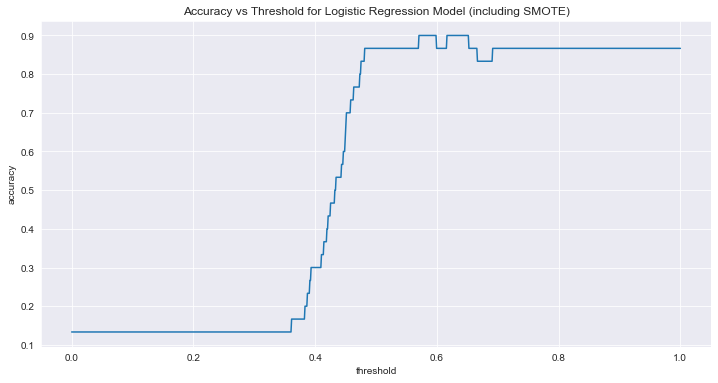

In [129]:
accuracies = np.array(
    [(i, accuracy_score(y_test, Y_pp_smote.class_1_pp.apply(predict_at_threshold, threshold=i))) 
        for i in np.linspace(0, 1, 1000)])
plt.figure(figsize=(12, 6))
plt.plot(accuracies[:, 0], accuracies[:, 1])
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.title('Accuracy vs Threshold for Logistic Regression Model (including SMOTE)')
plt.show()

In [130]:
# best accuracy score remains unchanged, but it occurs at a different threshold
accuracies[accuracies[:, 1].argmax()]

array([0.57057057, 0.9       ])

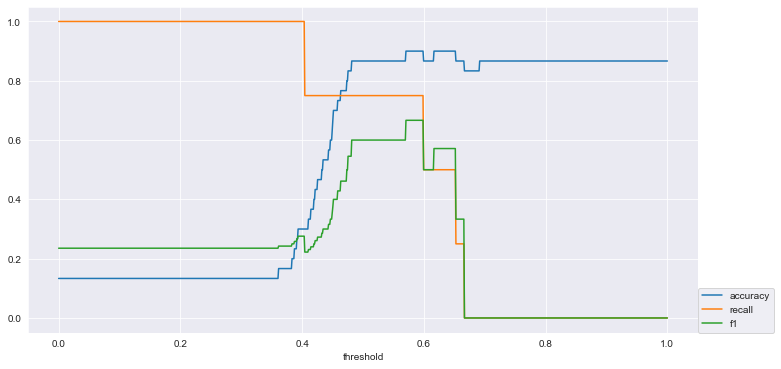

In [131]:
scores = scores_at_thresholds(Y_pp_smote.class_1_pp)

plt.figure(figsize=(12, 6))
plt.plot(scores[:, 0], scores[:, 1], label='accuracy')
plt.plot(scores[:, 0], scores[:, 2], label='recall')
plt.plot(scores[:, 0], scores[:, 3], label='f1')
plt.legend(loc=[1, 0])
plt.xlabel('threshold')
plt.show()

In [135]:
# best overall performance is at a threshold just under 0.6
# it is the same level of performance we got when we tweaked the threshold without SMOTE

scores_df = pd.DataFrame(scores, columns = ['threshold', 'accuracy', 'recall', 'f1'])
scores_df[scores_df['threshold'] >= 0.57]

threshold  accuracy  recall        f1
570   0.570571  0.900000    0.75  0.666667
571   0.571572  0.900000    0.75  0.666667
572   0.572573  0.900000    0.75  0.666667
573   0.573574  0.900000    0.75  0.666667
574   0.574575  0.900000    0.75  0.666667
..         ...       ...     ...       ...
995   0.995996  0.866667    0.00  0.000000
996   0.996997  0.866667    0.00  0.000000
997   0.997998  0.866667    0.00  0.000000
998   0.998999  0.866667    0.00  0.000000
999   1.000000  0.866667    0.00  0.000000

[430 rows x 4 columns]

**TRY OTHER MODELS**

- It looks like we can improve performance either by tweaking the threshold of the logistic regression model, or by using SMOTE in the pipeline.
- However, when we combine the two techniques we don't see any further gains.
- The next option is to try alternative models to Logistic Regression.

In [47]:
#create pipeline - polynomial features, standard scaler, random forest model

pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
ran_for = RandomForestClassifier(n_estimators = 500)
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_ran_for = Pipeline(steps=[('column_transformer', col_trans), ('standard_scaler', ss), ('ran_for', ran_for)])


#grid of parameters for logistic regression model

params_ran_for = {'ran_for__max_features': ['auto', None],
          'ran_for__criterion': ['gini', 'entropy'],
                 'ran_for__max_depth': [4, 7, 10, 15, None]}

gs_ran_for = GridSearchCV(estimator= pipe_ran_for,
                  param_grid = params_ran_for,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_ran_for.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('continuous',
                                                                         PolynomialFeatures(degree=3),
                                                                         ['total_attended',
                                                                          'node_centrality',
                                                                          'clustering',
                                                                          'degree'])])),
                                       ('standard_scaler', StandardScaler()),
                                       ('ran_for',
                                        RandomForestClassifier(n_estimators=500))]),
             n_jobs=-2,
             param_grid={'ran_for__criterion':

In [48]:
# check for cross_validated score on training set
print('gs_ran_for best_score:', gs_ran_for.best_score_, 'gs_ran_for best_params:', gs_ran_for.best_params_)

gs_ran_for best_score: 0.8905797101449275 gs_ran_for best_params: {'ran_for__criterion': 'gini', 'ran_for__max_depth': 4, 'ran_for__max_features': None}


In [140]:
# check performance on test set - performance is the same as the logistic regression model after it was tuned
predictions = gs_ran_for.predict(X_test)
print('test_accuracy ran for:', accuracy_score(y_test, predictions))
print('test_recall ran for:', recall_score(y_test, predictions))
print('test_f1 ran for:', f1_score(y_test, predictions))

test_accuracy ran for: 0.9
test_recall ran for: 0.75
test_f1 ran for: 0.6666666666666665


In [59]:
#create pipeline - polynomial features, standard scaler, KNN


pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
knn = KNeighborsClassifier()
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_knn = Pipeline(steps=[('column_transformer', col_trans), ('standard_scaler', ss), ('knn', knn)])


#grid of parameters for KNN model

params_knn = {'knn__n_neighbors': [2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50],
          'knn__weights': ['distance', 'uniform']}

gs_knn = GridSearchCV(estimator= pipe_knn,
                  param_grid = params_knn,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('continuous',
                                                                         PolynomialFeatures(degree=3),
                                                                         ['total_attended',
                                                                          'node_centrality',
                                                                          'clustering',
                                                                          'degree'])])),
                                       ('standard_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [2, 3, 4, 5, 7, 10, 15, 20, 30, 40,
                           

In [60]:
# check for cross_validated score on training set
print('gs_knn best_score:', gs_knn.best_score_, 'gs_knn best_params:', gs_knn.best_params_)

gs_knn best_score: 0.8655797101449275 gs_knn best_params: {'knn__n_neighbors': 2, 'knn__weights': 'uniform'}


In [179]:
# check KNN performance on test set - without SMOTE it fails to predict the minority class

predictions = gs_knn.predict(X_test)
print('test_accuracy knn:', accuracy_score(y_test, predictions))
print('test_recall knn:', recall_score(y_test, predictions))
print('test_f1 knn:', f1_score(y_test, predictions))

test_accuracy knn: 0.8333333333333334
test_recall knn: 0.0
test_f1 knn: 0.0


In [198]:
#create pipeline - polynomial features, standard scaler, Gradient Boosting Classifier

pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
gbc = GradientBoostingClassifier()
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_gbc = Pipeline(steps=[('column_transformer', col_trans), ('standard_scaler', ss), ('gbc', gbc)])


params_gbc = {
    "gbc__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "gbc__min_samples_split": [1,2,3],
    "gbc__min_samples_leaf": [1,2,3],
    "gbc__max_depth": [3,4,5],
    "gbc__max_features":["log2","sqrt"],
    "gbc__n_estimators":[10, 50, 100, 150, 200, 250, 300, 400, 500]
    }

gs_gbc = GridSearchCV(estimator= pipe_gbc,
                  param_grid = params_gbc,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.83188406 0.84021739 0.83188406]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('continuous',
                                                                         PolynomialFeatures(degree=3),
                                                                         ['total_attended',
                                                                          'node_centrality',
                                                                          'clustering',
                                                                          'degree'])])),
                                       ('standard_scaler', StandardScaler()),
                                       ('gbc', GradientBoostingClassifier())]),
             n_jobs=-2,
             param_grid={'gbc__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'gbc__

In [199]:
# check for cross_validated score on training set
print('gs_gbc best_score:', gs_gbc.best_score_, 'gs_gbc best_params:', gs_gbc.best_params_)

gs_gbc best_score: 0.8905797101449275 gs_gbc best_params: {'gbc__learning_rate': 0.01, 'gbc__max_depth': 3, 'gbc__max_features': 'log2', 'gbc__min_samples_leaf': 2, 'gbc__min_samples_split': 2, 'gbc__n_estimators': 200}


In [201]:
# check test scores for gradient boosting classifier

predictions = gs_gbc.predict(X_test)
print('test_accuracy gbc:', accuracy_score(y_test, predictions))
print('test_recall gbc:', recall_score(y_test, predictions))
print('test_f1 gbc:', f1_score(y_test, predictions))

test_accuracy gbc: 0.9
test_recall gbc: 0.5
test_f1 gbc: 0.5714285714285715


In [143]:
#create pipeline - polynomial features, standard scaler, Support Vector Classifier

pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
clf = svm.SVC()
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_svm = Pipeline(steps=[('column_transformer', col_trans), ('standard_scaler', ss), ('svm', clf)])


#grid of parameters for SVC

params_svm = {'svm__gamma': np.logspace(-5, 2, 10),
              'svm__C': np.logspace(-3, 2, 10), 
              'svm__kernel': ['rbf', 'sigmoid', 'poly']}

gs_svm = GridSearchCV(estimator= pipe_svm,
                  param_grid = params_svm,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_svm.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('continuous',
                                                                         PolynomialFeatures(degree=3),
                                                                         ['total_attended',
                                                                          'node_centrality',
                                                                          'clustering',
                                                                          'degree'])])),
                                       ('standard_scaler', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-2,
             param_grid={'svm__C': array([1.00000000e-03, 3.59381366e-03, 1...2, 4.64158883e-02,
       1.66810054e-01, 5.994

In [144]:
# check for cross_validated score on training set for SVM
print('gs_svm best_score:', gs_svm.best_score_, 'gs_svm best_params:', gs_svm.best_params_)

gs_svm best_score: 0.8905797101449275 gs_svm best_params: {'svm__C': 2.1544346900318843, 'svm__gamma': 0.0021544346900318843, 'svm__kernel': 'rbf'}


In [145]:
# check performance on test set - this is our best model so far
predictions = gs_svm.predict(X_test)
print('test_accuracy svm:', accuracy_score(y_test, predictions))
print('test_recall svm:', recall_score(y_test, predictions))
print('test_f1 svm:', f1_score(y_test, predictions))

test_accuracy svm: 0.9333333333333333
test_recall svm: 0.75
test_f1 svm: 0.75


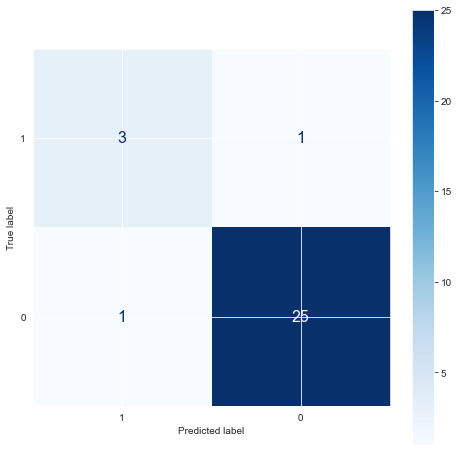

In [268]:
#visualise confusion matrix for best model

fig, ax = plt.subplots(figsize = (8, 8))

plot_confusion_matrix(gs_svm, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f', ax = ax)

texts = ax.texts
for text in texts:
    text.set_size(16)
plt.savefig('confusion.png')

In [207]:
#classification report for best model

predictions = gs_svm.predict(X_test)
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9615    0.9615    0.9615        26
           1     0.7500    0.7500    0.7500         4

    accuracy                         0.9333        30
   macro avg     0.8558    0.8558    0.8558        30
weighted avg     0.9333    0.9333    0.9333        30



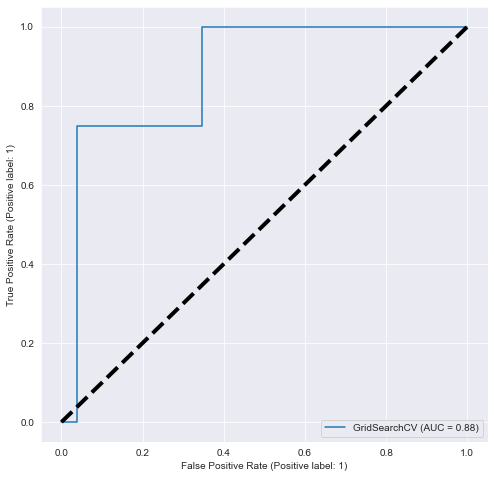

In [208]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(gs_svm, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

In [146]:
# build pipeline with SMOTE and SVC

smote_nc = SMOTENC(categorical_features = np.array(cat_index), random_state=0)
pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
clf = svm.SVC()
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_svm_smote = Pipeline(steps=[('smotenc', smote_nc), ('column_transformer', col_trans), ('standard_scaler', ss), ('svm', clf)])


# #grid of parameters for logistic regression model

#grid of parameters for SVC

params_svm = {'svm__gamma': np.logspace(-5, 2, 10),
              'svm__C': np.logspace(-3, 2, 10), 
              'svm__kernel': ['rbf', 'sigmoid', 'poly']}

gs_svm_smote = GridSearchCV(estimator= pipe_svm_smote,
                  param_grid = params_svm,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_svm_smote.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smotenc',
                                        SMOTENC(categorical_features=array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,...
             param_grid={'svm__C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'svm__gamma': array([1.00000000e-05, 5.99484250e-05, 3.59381366e-04, 2.15443469e-03,
       1.29154967e-02, 7.74263683e-02, 4.64158883e-01, 2.78255940e+00,
       1.66810054e+01, 1.00000000e+02]),
                   

In [222]:
# check for cross_validated score on training set for SVM with SMOTE
print('gs_svm_smote best_score:', gs_svm_smote.best_score_, 'gs_svm  smote best_params:', gs_svm_smote.best_params_)

gs_svm_smote best_score: 0.8822463768115943 gs_svm  smote best_params: {'svm__C': 0.001, 'svm__gamma': 1e-05, 'svm__kernel': 'rbf'}


In [223]:
#check for performance on test set (SVM with SMOTE)
predictions = gs_svm_smote.predict(X_test)
print('test_accuracy svm:', accuracy_score(y_test, predictions))
print('test_recall svm:', recall_score(y_test, predictions))
print('test_f1 svm:', f1_score(y_test, predictions))

test_accuracy svm: 0.8333333333333334
test_recall svm: 0.0
test_f1 svm: 0.0


In [218]:
# build pipeline with SMOTE and SVC, and underampling the majority class


smote_nc = SMOTENC(categorical_features = np.array(cat_index), random_state=0, sampling_strategy = 0.5)
under = RandomUnderSampler(sampling_strategy = 0.5, random_state = 0)
pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
clf = svm.SVC()
col_trans = ColumnTransformer([('continuous', pf, numeric_cols)], remainder = 'passthrough')
pipe_svm_smote_under = Pipeline(steps=[('smotenc', smote_nc), ('under', under), ('column_transformer', col_trans), ('standard_scaler', ss), ('svm', clf)])


# #grid of parameters for logistic regression model

#grid of parameters for SVC

params_svm = {'svm__gamma': np.logspace(-5, 2, 10),
              'svm__C': np.logspace(-3, 2, 10), 
              'svm__kernel': ['rbf', 'sigmoid', 'poly']}

gs_svm_smote_under = GridSearchCV(estimator= pipe_svm_smote_under,
                  param_grid = params_svm,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_svm_smote_under.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smotenc',
                                        SMOTENC(categorical_features=array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,...
             param_grid={'svm__C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'svm__gamma': array([1.00000000e-05, 5.99484250e-05, 3.59381366e-04, 2.15443469e-03,
       1.29154967e-02, 7.74263683e-02, 4.64158883e-01, 2.78255940e+00,
       1.66810054e+01, 1.00000000e+02]),
                   

In [220]:
# check for cross_validated score on training set for SVM with SMOTE and undersampling
print('gs_svm_smote best_score:', gs_svm_smote_under.best_score_, 'gs_svm  smote best_params:', gs_svm_smote_under.best_params_)

gs_svm_smote best_score: 0.8905797101449275 gs_svm  smote best_params: {'svm__C': 27.825594022071257, 'svm__gamma': 5.994842503189409e-05, 'svm__kernel': 'sigmoid'}


In [221]:
#check for performance on test set (SVM with SMOTE)
predictions = gs_svm_smote_under.predict(X_test)
print('test_accuracy svm:', accuracy_score(y_test, predictions))
print('test_recall svm:', recall_score(y_test, predictions))
print('test_f1 svm:', f1_score(y_test, predictions))

test_accuracy svm: 0.9
test_recall svm: 0.5
test_f1 svm: 0.5714285714285715


In [224]:
# Finally, check what happens when we take our best model (SVM without SMOTE and remove the NetworkX features)

df_final_reduced = df_final.drop(columns = ['node_centrality', 'clustering', 'degree'])

#separate the target variable
target = final_copy['31/10/2009']


#separate predictor variables and target variables
y = target
X_reduced = df_final_reduced


# dummify categorical variables
X_dummies_2 = pd.get_dummies(X_reduced, drop_first = True)


# split data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_dummies_2, y,
                        stratify = y, test_size=0.2, random_state = 1)


pf = PolynomialFeatures(degree = 3)
ss = StandardScaler()
clf = svm.SVC()
col_trans = ColumnTransformer([('continuous', pf, [0])], remainder = 'passthrough')
pipe_svm_reduced = Pipeline(steps=[('column_transformer', col_trans), ('standard_scaler', ss), ('svm', clf)])


#grid of parameters for SVC

params_svm = {'svm__gamma': np.logspace(-5, 2, 10),
              'svm__C': np.logspace(-3, 2, 10), 
              'svm__kernel': ['rbf', 'sigmoid', 'poly']}

gs_svm_reduced = GridSearchCV(estimator= pipe_svm_reduced,
                  param_grid = params_svm,
                  cv = 5,
                  scoring = 'accuracy',
                  n_jobs = -2,
                  verbose = 2)

gs_svm_reduced.fit(X_train_2, y_train_2)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('continuous',
                                                                         PolynomialFeatures(degree=3),
                                                                         [0])])),
                                       ('standard_scaler', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-2,
             param_grid={'svm__C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'svm__gamma': array([1.00000000e-05, 5.99484250e-05, 3.59381366e-04, 2.15443469e-03,
       1.29154967e-02, 7.74263683e-02, 4.64158883e-01, 2.78255940e+00,
      

In [227]:
# check for cross_validated score on training set for SVM with without networkx features
print('gs_svm_reduced best_score:', gs_svm_reduced.best_score_, 'gs_svm  reduced best_params:', gs_svm_reduced.best_params_)


gs_svm_reduced best_score: 0.8822463768115941 gs_svm  reduced best_params: {'svm__C': 2.1544346900318843, 'svm__gamma': 0.0021544346900318843, 'svm__kernel': 'rbf'}


In [228]:
# check performance on test set, SVM without NetworkX features

predictions = gs_svm_reduced.predict(X_test_2)
print('test_accuracy svm:', accuracy_score(y_test, predictions))
print('test_recall svm:', recall_score(y_test, predictions))
print('test_f1 svm:', f1_score(y_test, predictions))

test_accuracy svm: 0.9333333333333333
test_recall svm: 0.5
test_f1 svm: 0.6666666666666666


**SUMMARY OF MODEL SCORES**

- Logistic Regression: (including NetworkX features, default threshold)
- Cross_val training: 0.891
- Test Accuracy: 0.867
- Test Recall: 0.5
- Test F1: 0.5
- 

- Logistic Regression (NetworkX features stripped out)
- Cross val training: 0.866
- Test Accuracy: 0.867
- Test Recall: 0.000
- Test F1: 0.000
- 

- Logistic Regression (including NetworkX, tweaked threshold)
- Cross val training: NA
- Test Accuracy: 0.900
- Test Recall: 0.750
- Test F1: 0.667
- 

- Logistic Regression (including NetworkX, default threshold, SMOTE)
- Cross val training: 0.841
- Test Accuracy: 0.867
- Test Recall: 0.750
- Test F1: 0.600


- Logistic Regression (including NetworkX, default threshold, SMOTE, random undersampling)
- Cross val training: 0.882
- Test Accuracy: 0.900
- Test Recall: 0.500
- Test F1: 0.571
- 

- Logistic Regression (including NetworkX, tweaked threshold, SMOTE)
- Cross val training: NA
- Test Accuracy: 0.900
- Test Recall: 0.750
- Test F1: 0.667
- 

- Random Forest (including NetworkX features)
- Cross val training: 0.891
- Test Accuracy: 0.900
- Test Recall: 0.750
- Test F1: 0.667
- 

- KNN (including NetworkX features)
- Cross val training: 0.866
- Test Accuracy: 0.833
- Test Recall: 0.000
- Test F1: 0.000
- 

- GradientBoostingClassifier(including Network X features)
- Cross val training: 0.891
- Test Accuracy: 0.900
- Test Recall: 0.500
- Test F1: 0.571
- 

- SVM (including Network X features)
- Cross val training: 0.891
- Test Accuracy: 0.933
- Test Recall: 0.750
- Test F1: 0.750
- 
- SVM (Without Network X features)
- Cross val training: 0.882
- Test Accuracy: 0.933
- Test Recall: 0.500
- Test F1: 0.666
- 

- SVM (including NetworkX and SMOTE)
- Cross val training: 0.882
- Test Accuracy: 0.833
- Test Recall: 0.00
- Test F1: 0.000
- 

- SVM (including NetworkX, SMOTE, random underampling)
- Cross val training: 0.891
- Test Accuracy: 0.900
- Test Recall: 0.500
- Test F1: 0.571


In [230]:
#SVM predictions on reduced dataset

gs_svm_reduced.predict(X_test_2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0])

In [231]:
#SVM predictions on full dataset including NetworkX

gs_svm.predict(X_test)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0])

In [233]:
#y_test

y_test.values

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0])

In [236]:
#put them in a dataframe

pd.DataFrame(zip(gs_svm_reduced.predict(X_test_2), gs_svm.predict(X_test), y_test.values), columns = ['svm_reduced', 'svm', 'y_test'])

svm_reduced  svm  y_test
0             0    1       1
1             0    0       0
2             0    0       0
3             0    0       0
4             0    0       1
5             0    0       0
6             0    0       0
7             0    0       0
8             0    0       0
9             1    1       1
10            0    1       0
11            0    0       0
12            0    0       0
13            0    0       0
14            0    0       0
15            0    0       0
16            0    0       0
17            0    0       0
18            0    0       0
19            0    0       0
20            0    0       0
21            0    0       0
22            1    1       1
23            0    0       0
24            0    0       0
25            0    0       0
26            0    0       0
27            0    0       0
28            0    0       0
29            0    0       0

The only prediction where the model does better with the reduced dataset is the eleventh in the test set.

This is Cosimo Barranca (index 8 in mafia dataset - degree 53, high node centrality, low, clustering but didn't go to the summit - this is the only one where not having NetworkX data is an advantage).

Cosimo should definitely been invited on the basis of seniority - can we find a reason why he wasn't there, was he in prison? Was he ill?

This is a limitation to having to work with the Summit as a measure of seniority rather than a list from the prosecutor, this isn't the fault of the model or of NetworkX.


In [253]:
X_test.iloc[9:12, :]

total_attended  node_centrality  clustering  degree  18/10/2007(L)_1  \
57              13         0.056327    0.409148      57                0   
8               12         0.100870    0.295356      53                1   
45               1         0.000000    1.000000       6                0   

    29/11/2007(L)_1  02/02/2008(L)_1  15/02/2008(1)_1  15/02/2008(2)_1  \
57                0                0                1                1   
8                 1                1                0                0   
45                0                0                0                0   

    21/02/2008(L)_1  ...  surname_X_Carmelo  surname_X_Mario  surname_X_Mauro  \
57                0  ...                  0                0                0   
8                 1  ...                  0                0                0   
45                0  ...                  0                0                0   

    surname_X_Pino  surname_X_Raffaele  surname_ZANGARI  surname_ZAPPALÀ  \
57               0                   0                0                0   
8                0                   0                0                0   
45               0                   0                0                0   

    surname_ZAPPIA  surname_ZINGHINI  surname_ZOITI  
57               0                 0              0  
8                0                 0              0  
45               0                 0              0  

[3 rows x 158 columns]

**TRY SOME UNSUPERVISED CLUSTERING**

- Apparently the prosecutor claimed there are 17 known'LOCALI' or Ndranghetta groups in the Lombardy region.
- It would be interesting to see how a clustering algorythm divides up the network.
- Unfortunately without the true labels it's difficult to know if this provides us with anything useful.


In [ ]:
# def plot_communities(G, number_of_clusters=2, seed=10):
#     GN_communities = list(nx.community.girvan_newman(G))
#     pos = nx.drawing.spring_layout(G, seed=seed)
#     if number_of_clusters > G.number_of_nodes():
#         index = G.number_of_nodes()-2
#     else:
#         index = number_of_clusters - 2
#     G_sub = {}

#     label_dict = {}
#     for i, nodes in enumerate(GN_communities[index]):
#         for node in nodes:
#             label_dict[node] = i 
#     label_list = [label_dict[node] for node in G.nodes()]
#     fig, ax = plt.subplots(figsize = (30,30))

#     nx.draw(G, pos=pos, node_color = label_list, cmap='rainbow', with_labels = False, ax = ax)
    
#     plt.show()
    
    

    
# plot_communities(G_shortened, 2)

In [ ]:
# from scipy.cluster import hierarchy
# from sklearn.metrics import pairwise_distances
# from scipy.spatial.distance import pdist, cosine, jaccard

In [ ]:
# A = nx.adjacency_matrix(G_shortened).toarray()
# dist_out = pdist(A, metric='cosine')
# #dist_out = np.nan_to_num(dist_out)
# Z = hierarchy.linkage(dist_out, method='average')
# fig, ax = plt.subplots(figsize = (20, 42))
# hierarchy.dendrogram(Z, orientation = 'right', leaf_rotation=0, ax = ax, labels=list(G_shortened.nodes()))
# plt.yticks(fontsize = 12)
# plt.show()

In [ ]:
# visualise the network with each family shown in a different colour

# name_list = (nodes_df_shortened['surname'].unique())
# mapping_dict = {}
# for i, name in enumerate(name_list):
#     mapping_dict[name] = i
# fig, ax = plt.subplots(figsize = (50,50))
# position = nx.spring_layout(G_shortened, seed = 10)
# label_list = [mapping_dict[b['family_name']] for a,b in dict(G_shortened.nodes.data()).items()]
# nx.draw(G_shortened, pos = position, with_labels = False, ax = ax, font_size = 90, node_color = label_list, cmap='rainbow', node_size = 800)

In [ ]:
# visualise those families with more than two members

# name_list = (nodes_df_shortened['surname'].unique())
# mapping_dict = {}
# for i, name in enumerate(name_list):
#     mapping_dict[name] = i
# fig, ax = plt.subplots(figsize = (50,50))
# position = nx.spring_layout(G_shortened, seed = 10)
# label_list = [mapping_dict[b['family_name']] *1000 if b['family_size'] > 2 else 0 for a,b in dict(G_shortened.nodes.data()).items()]
# nx.draw(G_shortened, pos = position, with_labels = False, ax = ax, font_size = 90, node_color = label_list, cmap='viridis', node_size = 800)

In [ ]:
# yellow shows all families with more than one member

# name_list = (nodes_df_shortened['surname'].unique())
# mapping_dict = {}
# for i, name in enumerate(name_list):
#     mapping_dict[name] = i
# fig, ax = plt.subplots(figsize = (50,50))
# position = nx.spring_layout(G_shortened, seed = 10)
# label_list = [1000 if b['family_size'] > 1 else 0 for a,b in dict(G_shortened.nodes.data()).items()]
# nx.draw(G_shortened, pos = position, with_labels = False, ax = ax, font_size = 90, node_color = label_list, cmap='viridis', node_size = 800)

In [ ]:
# Show the family with six members

# fig, ax = plt.subplots(figsize = (50,50))
# position = nx.spring_layout(G_shortened, seed = 10)
# label_list = [node[1]['family_size'] == 6 for node in G_shortened.nodes.data()]
# nx.draw(G_shortened, pos = position, with_labels = False, ax = ax, font_size = 90, node_color = label_list, cmap='rainbow', node_size = 800)